# GALAH DR4 Spectrum Analysis assuming Single Source - coadded version that includes parallax information

This script is used to find the optimal set of stellar labels for GALAH spectra in combination with non-spectroscopic information

The code is maintained at
https://github.com/svenbuder/GALAH_DR4
and described at
https://github.com/svenbuder/galah_dr4_paper

Author(s): Sven Buder (ANU, ASTRO 3D)

History:  
220902 Created from code 'galah_dr4_spectrum_analysis_single'

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
import warnings
warnings.filterwarnings("ignore")
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import sys
import os
import glob
from pathlib import Path
from astropy.io import fits
import pickle
import scipy.interpolate
from scipy import signal
from scipy.spatial import cKDTree
from scipy.interpolate import Akima1DInterpolator,interp1d
from scipy.optimize import curve_fit

In [2]:
start_time = time.time()

In [3]:
# Create dictionary for descriptions
description = dict()
description['sobject_id'] = 'GALAH identifier'
description['tmass_id'] = '2MASS identifier'
description['gaia_edr3_source_id'] = 'Gaia DR2 source_id'
description['flag_sp'] = 'Spectroscopic quality flag'
description['teff'] = 'Spectroscopic effective temperature'
description['logg'] = 'Surface gravity'
description['fe_h'] = 'Fe abundance [Fe/H] (1D-NLTE)'
description['vmic'] = 'Microturbulence velocity'
description['vsini'] = 'Rotational broadening velocity'
for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    if element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Mn','Ba']:
        lte_nlte = 'NLTE'
    else:
        lte_nlte = 'LTE'        
    description[element.lower()+'_fe'] = element+' abundance ['+element+'/Fe] (1D-'+lte_nlte+')'
description['vrad'] = 'Radial velocity fitted from spectra'
description['rv_gauss'] = 'Radial velocity fitted from spectra with Gaussian'
for ccd in [1,2,3,4]:
    description['cdelt'+str(ccd)] = 'Linear wavelength increase per pixel for CCD'+str(ccd)
    description['crval'+str(ccd)] = 'Wavelength of first pixel for CCD'+str(ccd)
description['distance'] = 'Distance from Sun to star'
description['a_v'] = 'Extinction in V filter'
description['model_name'] = 'Model name used for label optimisation'
description['closest_model'] = 'Closest model needed for label optimisation'
description['spectrum_covariances'] = 'Covariances from CurveFit to spectra'

In [4]:
# Create dictionary for units
units = dict()
for each in description.keys():
    units[each] = ''
    if each in ['sobject_id','tmass_id','gaia_edr3_source_id','model_name','closest_model','spectrum_covariances','flag_sp']:
        pass
    elif each in ['teff']:
        units[each] = 'K'
    elif each in ['logg']:
        units[each] = 'log(cm.s**-2)'
    elif each in ['fe_h']:
        units[each] = 'dex'
    elif each in ['vmic','vsini','vrad','rv_gauss','e_rv_gauss']:
        units[each] = 'km s-1'
    elif each[-3:] == '_fe':
        units[each] = 'dex'
    elif each in ['distance']:
        units[each] = 'pc'
    elif each in ['a_v']:
        units[each] = 'mag'
    elif each[:5] in ['cdelt']:
        units[each] = 'Angstroem/pix'
    elif each[:5] in ['crval']:
        units[each] = 'Angstroem'
    else:
        print("'"+each+"',")

In [5]:
galah_dr4_directory = os.path.abspath(os.getcwd()+'/../')+'/'

In [6]:
repeat_table = Table.read(galah_dr4_directory+'observations/dr6.0_230101.fits')
init_values_table = Table.read('galah_dr4_initial_parameters_230101_lite.fits')

In [7]:
if sys.argv[1] != '-f':
    tmass_id = str(sys.argv[1])
else:
    tmass_id = 'VESTA' # VESTA
#     tmass_id = '13283993-4726329' # OmegaCen star with strong CNO
    
#     tmass_id = '23595997-5257480'
#     tmass_id = '00000011+0522500'
#     tmass_id = '00000024-5742487'
#     tmass_id = '00000023-5709445'
#     tmass_id = '00000025-7541166'
    
#     tmass_id = '00254416-7715157' # bet Hyi
#     tmass_id = '01440402-1556141' # tau Cet
#     tmass_id = '03013762-2805289' # eps For
#     tmass_id = '03021680+0405226' # alf Cet
#     tmass_id = '03325591-0927298' # eps Eri
#     tmass_id = '03402202-0313005' # HD 22879
#     tmass_id = '03431490-0945490' # del Eri
#     tmass_id = '04355524+1630331' # alf Tau
#     tmass_id = '06504983-0032270' # HD 49933
#     tmass_id = '09485609+1344395' # HD 84937
#     tmass_id = '09524585+2600248' # mu Leo
#     tmass_id = '11330013-3151273' # ksi Hya
#     tmass_id = '12202099+0318453' # HD 107328
#     tmass_id = '13544106+1823514' # eta Boo
#     tmass_id = '14153968+1910558' # Arcturus
#     tmass_id = '15430307-1056009' # HD 140283
#     tmass_id = '16153726-0822096' # 18 Sco
#     tmass_id = '17440870-5150027' # mu Ara
#     tmass_id = 'gam Sge' # gam Sge
#     tmass_id = '04060261-6430120' # Random star with Teff/logg/fe_h 6000 3.5 -0.25
#     tmass_id = '06152138-6015277' # star without parallax
#     tmass_id = '13321184-7706583' # issue with missing spectrum

#     tmass_id = '07413381-5948285'

In [8]:
spectrum = dict()
spectrum['tmass_id'] = tmass_id

spectrum['sobject_ids'] = list(repeat_table['sobject_id'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0]])
spectrum['sobject_id'] = spectrum['sobject_ids'][0]

print('TMASS ID:    ',tmass_id)
print('sobject_ids: ',spectrum['sobject_ids'])

TMASS ID:     VESTA
sobject_ids:  [210115002201239]


In [9]:
# neglect spectra observed with high-resolution
initial_list = list(spectrum['sobject_ids'])
for ind_sobject_id in initial_list:
    index_init_table = np.where(init_values_table['sobject_id'] == ind_sobject_id)[0]
    if len(index_init_table) > 0:
        index_init_table = index_init_table[0]
        if (init_values_table['reduction_flags'][index_init_table] >= 2**18) & (init_values_table['reduction_flags'][index_init_table] < 2**19):
            spectrum['sobject_ids'].remove(ind_sobject_id)
            if sys.argv[1] == '-f':
                print(str(ind_sobject_id)+' observed at high resolution. Dropping this one for the plxcom setup')
        elif ind_sobject_id in [131217003901033,141231005201174,140207003801201,140207004801201,140207005401201,140208005101201,140208005101210,140209004901151,140209004901160,140314005201099,140315002501099,140114005001164,140114005001166,140209004901160,140209005401160,140208004101201]: # 140710000801284
            spectrum['sobject_ids'].remove(ind_sobject_id)
            if sys.argv[1] == '-f':
                print('Manually removed spectrum '+str(ind_sobject_id))
        else:
            print(str(ind_sobject_id))
    else:
        if sys.argv[1] == '-f':
            print(str(ind_sobject_id)+' no entry found')
        spectrum['sobject_ids'].remove(ind_sobject_id)
        
if len(spectrum['sobject_ids'])==0:
    if sys.argv[1] == '-f':
        print('\nEither no useful spectrum available, or all at high-res. Testing 2nd case')
    spectrum['sobject_ids'] = initial_list
    for ind_sobject_id in initial_list:
        index_init_table = np.where(init_values_table['sobject_id'] == ind_sobject_id)[0]
        if len(index_init_table) > 0:
            index_init_table = index_init_table[0]
            if init_values_table['reduction_flags'][index_init_table] == 2**18:
                if sys.argv[1] == '-f':
                    print(str(ind_sobject_id)+' observed at high resolution.')
            else:
                if sys.argv[1] == '-f':
                    print(str(ind_sobject_id))
        else:
            print(str(ind_sobject_id)+' no entry found')
            spectrum['sobject_ids'].remove(ind_sobject_id)
    print(len(spectrum['sobject_ids']))

210115002201239


In [10]:
spectrum['sobject_ids'].sort()
spectrum['mjds'] = np.array(repeat_table['mjd'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0]],dtype=float)

sobject_id_initial_index = np.where(init_values_table['sobject_id'] == spectrum['sobject_ids'][0])[0]
if len(sobject_id_initial_index) > 0:
    if len(sobject_id_initial_index) > 1:
        if sys.argv[1] == '-f':
            print('Warn: More than one entry in initial parameter table for '+str(spectrum['sobject_id']))
    sobject_id_initial_index = sobject_id_initial_index[0]
else:
    if sys.argv[1] == '-f':
        print('No initial values found in 230101_lite catalogue.')

try:
    spectrum['gaia_edr3_source_id'] = np.int64(init_values_table['source_id'][sobject_id_initial_index])

except:
    spectrum['gaia_edr3_source_id'] = np.int64(-1)

spectrum['ebv'] = float(init_values_table['ebv'][sobject_id_initial_index].clip(min=0.0,max=0.72))

success = True

In [11]:
extra_info_all = Table.read('../auxiliary_information/dr60_230101_ebv_wise_tmass_gaiadr3corr_xmatch.fits', format='fits')
extra_info_match = np.where(extra_info_all['sobject_id'] == spectrum['sobject_id'])[0]
if spectrum['sobject_id'] == 140808000901102:
    extra_info_match = np.where(extra_info_all['sobject_id'] == 140208005101201)[0]
if spectrum['sobject_id'] == 210115002201239: # No matches for VESTA etc.
    extra_info_match = []

In [12]:
extra_info = dict()
extra_info['age'] = 4.5

if len(extra_info_match) > 0:
    if sys.argv[1] == '-f':
        print('Found extra information for star')
    for key in [
        'sobject_id','phot_g_mean_mag','phot_bp_mean_mag','bp_rp',
        'h_m','h_msigcom', 'ks_m', 'ks_msigcom', 'W2mag', 'e_W2mag',
        'parallax', 'radial_velocity','radial_velocity_error','ebv'
    ]:
        extra_info[key] = extra_info_all[key][extra_info_match[0]]
        if key == 'parallax':
            extra_info['e_'+key] = extra_info_all[key+'_error'][extra_info_match[0]]
            extra_info['parallax_gaia_edr3'] = extra_info_all[key][extra_info_match[0]]
            extra_info['e_parallax_gaia_edr3'] = extra_info_all[key+'_error'][extra_info_match[0]]

    extra_info['rv_gaia_dr3'] = extra_info_all['radial_velocity'][extra_info_match[0]]
    extra_info['e_rv_gaia_dr3'] = extra_info_all['radial_velocity_error'][extra_info_match[0]]
    extra_info['ruwe_gaia_dr3'] = extra_info_all['ruwe'][extra_info_match[0]]

    if np.isfinite(extra_info_all['r_med_photogeo'][extra_info_match[0]]):
        extra_info['r_med'] = extra_info_all['r_med_photogeo'][extra_info_match[0]]
        extra_info['r_lo'] = extra_info_all['r_lo_photogeo'][extra_info_match[0]]
        extra_info['r_hi'] = extra_info_all['r_hi_photogeo'][extra_info_match[0]]
    elif np.isfinite(extra_info_all['r_med_geo'][extra_info_match[0]]):
        extra_info['r_med'] = extra_info_all['r_med_geo'][extra_info_match[0]]
        extra_info['r_lo'] = extra_info_all['r_lo_geo'][extra_info_match[0]]
        extra_info['r_hi'] = extra_info_all['r_hi_geo'][extra_info_match[0]]
    elif np.isfinite(extra_info_all['parallax'][extra_info_match[0]]):
        extra_info['r_med'] = 1000. /extra_info['parallax']
        extra_info['r_lo'] = 1000. /(extra_info['parallax']+extra_info['e_parallax'])
        extra_info['r_hi'] = 1000. /(extra_info['parallax']-extra_info['e_parallax'])
    else:
        extra_info['r_med'] = np.nan
        extra_info['r_lo'] = np.nan
        extra_info['r_hi'] = np.nan

    if (np.isfinite(extra_info['h_m']) & np.isfinite(extra_info['W2mag'])):
        extra_info['a_ks'] = (0.918 * (extra_info['h_m'] - extra_info['W2mag'] - 0.08)).clip(min=0.00,max=0.50)
        print('A(Ks)  via E(B-V) = '+"{:.2f}".format(spectrum['ebv'])+': '+"{:.2f}".format(0.36 * spectrum['ebv']))
        print('A(Ks) from RJCE (H & W2): '+"{:.2f}".format(extra_info['a_ks'])+' +- '+"{:.2f}".format(np.sqrt(extra_info_all['h_msigcom'][extra_info_match[0]]**2+extra_info_all['e_W2mag'][extra_info_match[0]]**2)))
        if (extra_info_all['tmass_ph_qual'][extra_info_match[0]][1] != 'A') | (extra_info_all['qph'][extra_info_match[0]][1] != 'A'):
            print('RJCE Quality not good ('+str(extra_info_all['tmass_ph_qual'][extra_info_match[0]][1])+' & '+str(extra_info_all['qph'][extra_info_match[0]][1])+'), using 0.36 * E(B-V) instead')
            if np.isfinite(spectrum['ebv']):
                extra_info['a_ks'] = 0.36*spectrum['ebv']
                if extra_info['a_ks'] < 0:
                    extra_info['a_ks'] = 0.0
                elif extra_info['a_ks'] > 0.5:
                    extra_info['a_ks'] = 0.5
            else:
                extra_info['a_ks'] = 0.00 # No measurement, so let's assume 0
    else:
        print('No finite H or W2; using E(B-V)')
        if np.isfinite(spectrum['ebv']):
            extra_info['a_ks'] = 0.36*spectrum['ebv']
            if extra_info['a_ks'] < 0:
                extra_info['a_ks'] = 0.0
            elif extra_info['a_ks'] > 0.5:
                extra_info['a_ks'] = 0.5
        else:
            extra_info['a_ks'] = 0.00 # No measurement, so let's assume 0

else:
    if sys.argv[1] == '-f':
        print('Found no extra information for star, should not run this star')
    extra_info['r_med'] = np.nan
    extra_info['r_lo'] = np.nan
    extra_info['r_hi'] = np.nan

if np.isnan(extra_info['r_med']):
    print('No finite distance available!')

if spectrum['sobject_id'] in [140710008301032,131220004401099,140207004801201]:
    if sys.argv[1] == '-f':
        print('Adjusting Ks magnitude')
    if spectrum['sobject_id'] == 140710008301032:
        extra_info['ks_m'] = 1.43 # * u.mag
        extra_info['ks_msigcom'] = 0.02 # * u.mag
    if spectrum['sobject_id'] == 131220004401099:
        extra_info['ks_m'] = 1.46 # * u.mag
        extra_info['ks_msigcom'] = 0.03 # * u.mag
    if spectrum['sobject_id'] == 140207004801201:
        extra_info['ks_m'] = 2.20 # * u.mag
        extra_info['ks_msigcom'] = 0.01 # * u.mag

if spectrum['sobject_id'] in [210115002201239,150210005801171,140710006601104,140709004401117,140708005801203,141102003801353,140710000801284,140709001901194]:
    if sys.argv[1] == '-f':
        print('Special star (will add extra information manually)')
    
    extra_info['sobject_id'] = spectrum['sobject_id']
    if spectrum['sobject_id'] == 210115002201239:
        extra_info['ks_m'] = 3.28 # * u.mag
        extra_info['ks_msigcom'] = 0.02 # * u.mag
        extra_info['parallax'] = 100.0 # * u.mas
        extra_info['e_parallax'] = 0.1 # * u.mas
    if spectrum['sobject_id'] == 150210005801171:
        extra_info['ks_m'] = -3.00 # * u.mag
        extra_info['ks_msigcom'] = 0.03 # * u.mag
        extra_info['parallax'] = 88.83 # * u.mas
        extra_info['e_parallax'] = 0.54 # * u.mas
    if spectrum['sobject_id'] == 140710006601104:
        extra_info['ks_m'] = -1.68 # * u.mag
        extra_info['ks_msigcom'] = 0.05 # * u.mag
        extra_info['parallax'] = 13.09 # * u.mas
        extra_info['e_parallax'] = 0.44 # * u.mas
    if spectrum['sobject_id'] == 140709004401117:
        extra_info['ks_m'] = -0.16 # * u.mag
        extra_info['ks_msigcom'] = 0.04 # * u.mag
        extra_info['parallax'] = 12.62 # * u.mas
        extra_info['e_parallax'] = 0.18 # * u.mas
    if spectrum['sobject_id'] == 140708005801203:
        extra_info['parallax'] = 134.07 # * u.mas
        extra_info['e_parallax'] = 0.11 # * u.mas
    if spectrum['sobject_id'] == 141102003801353:
        extra_info['ks_m'] = -2.84 # * u.mag
        extra_info['ks_msigcom'] = 0.06 # * u.mag
        extra_info['parallax'] = 48.94 # * u.mas
        extra_info['e_parallax'] = 0.77 # * u.mas
    if spectrum['sobject_id'] == 140710000801284:
        extra_info['ks_m'] = 2.20 # * u.mag
        extra_info['ks_msigcom'] = 0.01 # * u.mag
        extra_info['parallax'] = 9.705958463334975 # * u.mas
        extra_info['e_parallax'] = 0.15301941 # * u.mas
    if spectrum['sobject_id'] == 140709001901194:
        extra_info['ks_m'] = 1.36 # * u.mag
        extra_info['ks_msigcom'] = 0.02 # * u.mag
        extra_info['parallax'] = 87.75 # * u.mas
        extra_info['e_parallax'] = 1.24 # * u.mas  
    
    extra_info['r_med'] = 1000. /extra_info['parallax']
    extra_info['r_lo'] = 1000. /(extra_info['parallax']+extra_info['e_parallax'])
    extra_info['r_hi'] = 1000. /(extra_info['parallax']-extra_info['e_parallax'])
    
    spectrum['ebv'] = 0.0
    extra_info['a_ks'] = 0.0
    
    for key in ['rv_gaia_dr3','e_rv_gaia_dr3','ebv','ruwe_gaia_dr3']:
        extra_info[key] = np.NaN

if extra_info['parallax'] > 10.:
    if sys.argv[1] == '-f':
        print('Star within 100 pc, nulling E(B-V) and A(Ks)')
    spectrum['ebv'] = 0.0
    extra_info['a_ks'] = 0.0

if extra_info['a_ks'] > 2 * 0.36 * spectrum['ebv']:
    extra_info['a_ks'] = 0.36 * spectrum['ebv']
    print('A(Ks) estimate 2 times higher than 0.36 * E(B-V). Lowering to that 0.36 * E(B-V): '+"{:.2f}".format(extra_info['a_ks']))    

if  spectrum['ebv'] > 2 * extra_info['a_ks'] / 0.36:
    spectrum['ebv'] = 2.78 * extra_info['a_ks']
    print('E(B-V) estimate 2 times higher than A(Ks)/0.36. Lowering to A(Ks)/0.36: '+"{:.2f}".format(spectrum['ebv']))    

Found no extra information for star, should not run this star
No finite distance available!
Special star (will add extra information manually)
Star within 100 pc, nulling E(B-V) and A(Ks)


In [13]:
# Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
cantatgaudin2020_parallaxes = Table.read('../auxiliary_information/CantatGaudin_2020_AandA_640_1.fits')
cantatgaudin2020_match = np.where(spectrum['gaia_edr3_source_id'] == cantatgaudin2020_parallaxes['GaiaDR2'])[0]
# If there is an entry in this catalog
if len(cantatgaudin2020_match) > 0:
    extra_info['parallax_cg2020'] = cantatgaudin2020_parallaxes['plx'][cantatgaudin2020_match[0]] # * u.mas
    extra_info['e_parallax_cg2020'] = cantatgaudin2020_parallaxes['e_plx'][cantatgaudin2020_match[0]] # * u.mas
    # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
    if extra_info['e_parallax_cg2020'] < extra_info['e_parallax']:
        print('Open cluster entry by Cantat-Gaudin et al. (2020) more precise')
        extra_info['parallax'] = extra_info['parallax_cg2020']
        extra_info['e_parallax'] = extra_info['e_parallax_cg2020']
        extra_info['r_med'] = 1000. /extra_info['parallax']
        extra_info['r_lo'] = 1000. /(extra_info['parallax']+extra_info['e_parallax'])
        extra_info['r_hi'] = 1000. /(extra_info['parallax']-extra_info['e_parallax'])
    else:
        print('Open cluster entry by Cantat-Gaudin et al. (2020) less precise')
        print(r'Gaia EDR3:                   $'+"{:.3f}".format(extra_info['parallax'])+' \pm '+"{:.3f}".format(extra_info['e_parallax'])+'$')
        print(r'Cantat-Gaudin et al. (2020): $'+"{:.3f}".format(extra_info['parallax_cg2020'])+' \pm '+"{:.3f}".format(extra_info['e_parallax_cg2020'])+'$')
    extra_info['age'] = np.round(10**(cantatgaudin2020_parallaxes['logAge'][cantatgaudin2020_match[0]]-9),2)
    print('Open cluster age / Gyr: ',extra_info['age'])
else:
    print('No entry in Cantat-Gaudin et al. (2020) found')

if spectrum['sobject_id'] == 140307003101118:
    spectrum['gaia_edr3_source_id'] = 6083713495698719744
    for key in ['parallax','e_parallax','r_med','r_lo','r_hi']:
        extra_info[key] = np.NaN
    extra_info['j_m'] = 11.231
    extra_info['j_msigcom'] = 0.033
    extra_info['h_m'] = 10.774
    extra_info['h_msigcom'] = 0.046
    extra_info['ks_m'] = 10.599
    extra_info['ks_msigcom'] = 0.030
    
if spectrum['sobject_id'] == 140808004201212:
    spectrum['gaia_edr3_source_id'] = 4689830994171444096
    for key in ['parallax','e_parallax','r_med','r_lo','r_hi']:
        extra_info[key] = np.NaN
    extra_info['j_m'] = 11.985
    extra_info['j_msigcom'] = 0.029
    extra_info['h_m'] = 11.512
    extra_info['h_msigcom'] = 0.032
    extra_info['ks_m'] = 11.434
    extra_info['ks_msigcom'] = 0.030
    
if spectrum['sobject_id'] == 140303002001034:
    spectrum['gaia_edr3_source_id'] = 6083511804012335872
    for key in ['parallax','e_parallax','r_med','r_lo','r_hi']:
        extra_info[key] = np.NaN
    extra_info['j_m'] = 12.528
    extra_info['j_msigcom'] = 0.041
    extra_info['h_m'] = 12.111
    extra_info['h_msigcom'] = 0.058
    extra_info['ks_m'] = 11.927
    extra_info['ks_msigcom'] = 0.042   
    
if spectrum['sobject_id'] == 140305003201024:
    spectrum['gaia_edr3_source_id'] = 6083515033827932800
    for key in ['parallax','e_parallax','r_med','r_lo','r_hi']:
        extra_info[key] = np.NaN
    extra_info['j_m'] = 11.698
    extra_info['j_msigcom'] = 0.033
    extra_info['h_m'] = 11.225
    extra_info['h_msigcom'] = 0.035
    extra_info['ks_m'] = 11.078
    extra_info['ks_msigcom'] = 0.033
    
if spectrum['sobject_id'] == 210803002201013:
    spectrum['gaia_edr3_source_id'] = 6045465918541687296
    for key in ['parallax','e_parallax','r_med','r_lo','r_hi']:
        extra_info[key] = np.NaN

# Check entries in open cluster catalog by Cantat-Gaudin et al., 2020, A&A 640, 1
vasiliev2021_parallaxes = Table.read('../auxiliary_information/VasilievBaumgardt_2021_MNRAS_505_5978_cluster_source_id_memberprob0p7.fits')
vasiliev2021_match = np.where(spectrum['gaia_edr3_source_id'] == vasiliev2021_parallaxes['source_id'])[0]    

# If there is an entry in this catalog
if len(vasiliev2021_match) > 0:
    print('Match found in '+vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]])
    # replace parallax to be used, if Cantat-Gaudin et al. parallax has smaller uncertainty
    
    globular_clusters = Table.read('../auxiliary_information/GlobularClustersGALAHDR4.fits')
    correct_cluster = np.where(globular_clusters['Cluster'] == vasiliev2021_parallaxes['cluster'][vasiliev2021_match[0]])[0]
    if len(correct_cluster) > 0:
        correct_cluster = globular_clusters[correct_cluster[0]]
        extra_info['parallax_vb21'] = correct_cluster['parallax']
        extra_info['e_parallax_vb21'] = correct_cluster['e_parallax']
        extra_info['r_med_vb21'] = correct_cluster['r_med']
        extra_info['r_lo_vb21'] = correct_cluster['r_lo']
        extra_info['r_hi_vb21'] = correct_cluster['r_hi']
    else:
        raise ValueError('No extra information for Globular Cluster in auxiliary_information/GlobularClustersGALAHDR4.fits')
    
    if extra_info['e_parallax_vb21'] < extra_info['e_parallax']:
        print('Globular cluster entry by Vasiliev & Baumgardt (2021) more precise for plx (and better for distance)')
    else:
        print('Globular cluster entry by Vasiliev & Baumgardt (2021) less precise for plx (but better for distance):')

    print(r'Gaia EDR3:                   $'+"{:.3f}".format(extra_info['parallax'])+' \pm '+"{:.3f}".format(extra_info['e_parallax'])+'$, R / pc = ',"{:.0f}".format(extra_info['r_med']),"{:.0f}".format(extra_info['r_lo']-extra_info['r_med']),"{:.0f}".format(extra_info['r_hi']-extra_info['r_med']))
    print(r'Vasiliev & Baumgardt (2021): $'+"{:.3f}".format(extra_info['parallax_vb21'])+' \pm '+"{:.3f}".format(extra_info['e_parallax_vb21'])+'$, R / pc = ',"{:.0f}".format(extra_info['r_med_vb21']),"{:.0f}".format(extra_info['r_lo_vb21']-extra_info['r_med_vb21']),"{:.0f}".format(extra_info['r_hi_vb21']-extra_info['r_med_vb21']))
    extra_info['parallax'] = extra_info['parallax_vb21']
    extra_info['e_parallax'] = extra_info['e_parallax_vb21']
    extra_info['r_med'] = extra_info['r_med_vb21']
    extra_info['r_lo'] = extra_info['r_lo_vb21']
    extra_info['r_hi'] = extra_info['r_hi_vb21']

else:
    print('No entry in Vasiliev & Baumgardt (2021) found')

No entry in Cantat-Gaudin et al. (2020) found
No entry in Vasiliev & Baumgardt (2021) found


# Read in single star analysis results

In [14]:
single_results = dict()
single_results['sobject_id'] = []
single_results['rv_gauss'] = []
single_results['e_rv_gauss'] = []
single_results['mjd'] = []
single_results['flag_sp_fit'] = []
single_results['teff'] = []
single_results['logg'] = []
single_results['fe_h'] = []
single_results['vmic'] = []
single_results['vsini'] = []
single_results['e_vsini'] = []

for sobject_id,mjd in zip(spectrum['sobject_ids'],spectrum['mjds']):
    if len(glob.glob(galah_dr4_directory+'analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')) > 0:
        results = Table.read(galah_dr4_directory+'analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
        single_results['sobject_id'].append(sobject_id)
        single_results['rv_gauss'].append(results['rv_gauss'][0])
        single_results['e_rv_gauss'].append(results['e_rv_gauss'][0])
        single_results['mjd'].append(mjd)
        single_results['flag_sp_fit'].append(results['flag_sp_fit'][0])
        single_results['teff'].append(results['teff'][0])
        single_results['logg'].append(results['logg'][0])
        single_results['fe_h'].append(results['fe_h'][0])
        single_results['vmic'].append(results['vmic'][0])
        single_results['vsini'].append(results['vsini'][0])
        single_results['e_vsini'].append(results['cov_e_vsini'][0])
        if sys.argv[1] == '-f':
            print('Read in '+str(sobject_id))
    else:
        if sys.argv[1] == '-f':
            print('Could not read in '+str(sobject_id)+'. Using DR4 Initial Value')
            
        index_init_table = np.where(init_values_table['sobject_id'] == sobject_id)[0]
        single_results['sobject_id'].append(sobject_id)
        single_results['rv_gauss'].append(init_values_table['vrad'][index_init_table][0])
        single_results['e_rv_gauss'].append(1000.)
        single_results['mjd'].append(mjd)
        single_results['flag_sp_fit'].append(2**16)
        single_results['teff'].append(init_values_table['teff'][index_init_table][0])
        single_results['logg'].append(init_values_table['logg'][index_init_table][0])
        single_results['fe_h'].append(init_values_table['fe_h'][index_init_table][0])
        single_results['vmic'].append(init_values_table['vmic'][index_init_table][0])
        single_results['vsini'].append(init_values_table['vsini'][index_init_table][0])
        single_results['e_vsini'].append(40.)
        
for label in ['rv_gauss','e_rv_gauss','mjd','flag_sp_fit','teff','logg','fe_h','vmic','vsini','e_vsini']:
    single_results[label] = np.array(single_results[label])

Read in 210115002201239


# Get our initial information

In [15]:
spectrum['flag_sp'] = np.int32(0)
flag_sp_closest_3x3x3_model_not_available = np.int32(1)
flag_sp_closest_extra6_model_not_available = np.int32(2)
flag_sp_no_successful_convergence_within_maximum_loops = np.int32(4)
flag_sp_not_all_ccds_available = np.int32(8)
flag_sp_negative_fluxes_in_ccds = np.int32(16)
flag_sp_negative_resolution_profile = np.int32(32)

In [16]:
unflagged_single_measurements = (single_results['flag_sp_fit'] == 0)
len_unflagged = len(single_results['flag_sp_fit'][unflagged_single_measurements])

available_single_measurements = (single_results['flag_sp_fit'] < 128)
len_available = len(single_results['flag_sp_fit'][available_single_measurements])

if len_available == 0:
    available_single_measurements = np.isfinite(single_results['teff'])
    len_available = len(single_results['flag_sp_fit'][available_single_measurements])
    print('No measurements with flag_sp below 128 available. Using '+str(len_available)+' finite value(s).')

if len_unflagged > 0:
    if sys.argv[1] == '-f':
        print(str(len_unflagged)+' unflagged single measurement(s) available.')
    use_for_starting_values = unflagged_single_measurements
else:
    use_for_starting_values = available_single_measurements

rv_mean,rv_sigma = (np.mean(single_results['rv_gauss'][use_for_starting_values]),np.std(single_results['rv_gauss'][use_for_starting_values]))
if sys.argv[1] == '-f':
    print(r'RV (mean ± sigma) = '+"{:.2f}".format(rv_mean)+r' ± '+"{:.2f}".format(rv_sigma)+' km/s')

1 unflagged single measurement(s) available.
RV (mean ± sigma) = -21.28 ± 0.00 km/s


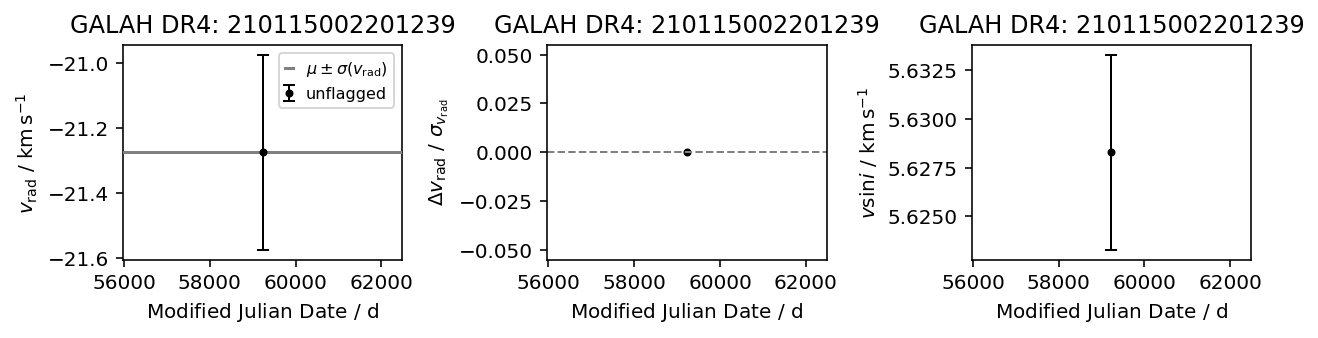

In [17]:
f, gs = plt.subplots(1,3,figsize=(9,2.5))

ax = gs[0]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))
if np.isfinite(rv_mean):
    ax.axhspan(
        rv_mean - rv_sigma,
        rv_mean + rv_sigma,
        alpha=0.15,zorder=1,color='grey'
    )
    ax.axhline(
        rv_mean,zorder=3,color='grey',label=r'$\mu \pm \sigma(v_\mathrm{rad})$'
    )
    
if np.isfinite(extra_info['rv_gaia_dr3']):
    ax.axhspan(
        extra_info['rv_gaia_dr3']-extra_info['e_rv_gaia_dr3'],
        extra_info['rv_gaia_dr3']+extra_info['e_rv_gaia_dr3'],
        alpha=0.25,zorder=2
    )
    ax.axhline(
        extra_info['rv_gaia_dr3'],zorder=4,label='$Gaia$ DR3'
    )
    ax.text(0.5,0.9,'$Gaia$ DR3 RUWE: '+"{:.2f}".format(extra_info['ruwe_gaia_dr3']),transform=ax.transAxes,ha='center')

if (len_available > 0) & (len_available != len_unflagged):
    ax.errorbar(
        single_results['mjd'][available_single_measurements],
        single_results['rv_gauss'][available_single_measurements],
        yerr = 10*np.array(single_results['e_rv_gauss'][available_single_measurements]),
        ms=3,c='grey',capsize=3,lw=1,
        fmt='o',zorder=5,label='flagged'
    )
if len_unflagged > 0:
    ax.errorbar(
        single_results['mjd'][unflagged_single_measurements],
        single_results['rv_gauss'][unflagged_single_measurements],
        yerr = 10*np.array(single_results['e_rv_gauss'][unflagged_single_measurements]),
        ms=3,c='k',capsize=3,lw=1,
        fmt='o',zorder=6,label='unflagged'
    )
ax.legend(handlelength=0.5,fontsize=8)
ax.yaxis.set_major_locator(MaxNLocator(4)) 
ax.xaxis.set_major_locator(MaxNLocator(4)) 
ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')

ax = gs[1]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))

ax.axhline(c='grey',lw=1,ls='dashed')
if (len_available > 0) & (len_available != len_unflagged):
    ax.scatter(
        single_results['mjd'][available_single_measurements],
        # (single_results['rv_gauss'][available_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][available_single_measurements]**2 + rv_sigma**2)
        (single_results['rv_gauss'][available_single_measurements] - rv_mean) / np.sqrt((10*single_results['e_rv_gauss'][available_single_measurements])**2 + 0.1**2),
        c='grey',s=9
    )
if len_unflagged > 0:
    ax.scatter(
        single_results['mjd'][unflagged_single_measurements],
        # (single_results['rv_gauss'][unflagged_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][unflagged_single_measurements]**2 + rv_sigma**2)
        (single_results['rv_gauss'][unflagged_single_measurements] - rv_mean) / np.sqrt((10*single_results['e_rv_gauss'][unflagged_single_measurements])**2 + 0.1**2),
        c='k',s=9
    )

ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\sigma_{v_\mathrm{rad}}$')

ax = gs[2]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))

if (len_available > 0) & (len_available != len_unflagged):
    ax.errorbar(
        single_results['mjd'][available_single_measurements],
        single_results['vsini'][available_single_measurements],
        yerr=single_results['e_vsini'][available_single_measurements],
        ms=3,c='grey',capsize=3,lw=1,
        fmt='o',zorder=5,label='flagged'
    )
if len_unflagged > 0:
    ax.errorbar(
        single_results['mjd'][unflagged_single_measurements],
        single_results['vsini'][unflagged_single_measurements],
        yerr=single_results['e_vsini'][unflagged_single_measurements],
        ms=3,c='k',capsize=3,lw=1,
        fmt='o',zorder=6,label='unflagged'
    )

ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$v \sin i~/~\mathrm{km\,s^{-1}}$')

plt.tight_layout()

file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

plt.savefig(file_directory+str(spectrum['sobject_id'])+'_plxcom_rv_comparison.png',bbox_inches='tight')

if sys.argv[1] == '-f':
    plt.show()
plt.close()

In [18]:
rv_difference_sigma = np.abs(single_results['rv_gauss'][use_for_starting_values] - rv_mean) / np.sqrt((10*single_results['e_rv_gauss'][use_for_starting_values])**2 + 0.1**2),
if np.max(rv_difference_sigma) > 2:
    spectrum['fit_global_rv'] = False
    if sys.argv[1] == '-f':
        print('RV difference above 2 sigma. Applying initial RV correction and not fitting global RV.')
        print('Fixing global RV init_vrad to 0.0 and applying single_fit RV estimates.')
    spectrum['init_vrad'] = 0.0
else:
    spectrum['fit_global_rv'] = True
    if sys.argv[1] == '-f':
        print('RV difference below 2 sigma. Applying no initial RV correction and fitting global RV.')
    spectrum['init_vrad'] = np.median(single_results['rv_gauss'][use_for_starting_values])
    if sys.argv[1] == '-f':
        print('Starting fit of global RV from init_vrad '+"{:.2f}".format(spectrum['init_vrad']))

RV difference below 2 sigma. Applying no initial RV correction and fitting global RV.
Starting fit of global RV from init_vrad -21.28


In [19]:
for label in ['teff','logg','fe_h','vmic','vsini']:
    spectrum['init_'+label] = np.median(single_results[label][use_for_starting_values])
    if label == 'teff':
        spectrum['init_'+label] /= 1000.
    if label == 'fe_h':
        if spectrum['init_'+label] > 0.8:
            spectrum['init_'+label] = np.float32(-0.07)
            print('[Fe/H] > 0.8, nulling.')

if spectrum['sobject_id'] in [140414004601184,140309003101001,140113002401230]:
    spectrum['init_teff'] = np.float32(3.2)
if spectrum['tmass_id'] == '13255577-4717440':
    spectrum['init_teff'] = np.float32(4.5)
    spectrum['init_logg'] = np.float32(1.5)
    spectrum['init_fe_h'] = np.float32(-1.8)
    spectrum['init_vsini'] = np.float32(5.)
            
spectrum['init_teff'] = spectrum['init_teff'].clip(min=3.01,max=7.99)

# We know if a bias for low [Fe/H] for giants
if (spectrum['init_teff'] >= 4.0) & (spectrum['init_teff'] <= 5.0) & (spectrum['init_teff'] <= 5.0) & (spectrum['init_logg'] <= 2.5):
    spectrum['init_logg'] += 0.1 - 0.3 * (spectrum['init_teff'] - 5.)
    spectrum['init_fe_h'] += 0.07 - 0.15 * (spectrum['init_teff'] - 5.)
    print('Identified giant with 4000-5000K: logg increased by '+"{:.2f}".format(0.1 - 0.3 * (spectrum['init_teff'] - 5.))+', [Fe/H] increased by '+"{:.2f}".format(0.07 - 0.15 * (spectrum['init_teff'] - 5.))+'\n')
else:
    print('Applying usual offset for logg and [Fe/H] of +0.1 and +0.07\n')
    spectrum['init_logg'] = spectrum['init_logg'] + 0.1
    spectrum['init_fe_h'] = spectrum['init_fe_h'] + 0.07

spectrum['init_logg'] = spectrum['init_logg'].clip(min=-0.4,max=5.3)
spectrum['init_fe_h'] = spectrum['init_fe_h'].clip(min=-3.9,max=0.7)

spectrum['init_vmic'] = spectrum['init_vmic'].clip(min=0.35,max=3.9)
if (spectrum['init_teff'] < 4.5) & (spectrum['init_logg'] > 4.0):
    spectrum['init_vmic'] = spectrum['init_vmic'].clip(min=0.35,max=1.5)
spectrum['init_vsini'] = spectrum['init_vsini'].clip(min=1.2,max=39)

print('Initial values:')
print('RV = '+"{:.2f}".format(spectrum['init_vrad'])+' (Gaia DR3: '+"{:.2f}".format(extra_info['rv_gaia_dr3'])+')')
print('Teff, logg, fe_h, vmic, vsini')
print(str(np.int32(1000*spectrum['init_teff']))+', '+"{:.2f}".format(spectrum['init_logg'])+', '+"{:.2f}".format(spectrum['init_fe_h'])+', '+"{:.2f}".format(spectrum['init_vmic'])+', '+"{:.2f}".format(spectrum['init_vsini']))
print()

for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    spectrum['init_'+element.lower()+'_fe'] = 0.0
    
alpha_fe = np.max([0.0,np.min([0.4,-0.4*spectrum['init_fe_h']])])
for each_alpha in ['o','mg','si','ca','ti']:
    spectrum['init_'+each_alpha+'_fe'] = alpha_fe
if sys.argv[1] == '-f': print('Enhancing [X/Fe] to '+"{:.2f}".format(alpha_fe)+' based on [Fe/H] for O, Mg, Si, Ca, and Ti ▔\▁') 

Applying usual offset for logg and [Fe/H] of +0.1 and +0.07

Initial values:
RV = -21.28 (Gaia DR3: nan)
Teff, logg, fe_h, vmic, vsini
5750, 4.43, 0.05, 0.99, 5.63

Enhancing [X/Fe] to 0.00 based on [Fe/H] for O, Mg, Si, Ca, and Ti ▔\▁


In [20]:
# Test if we should also include younger isocheones < 100 Myr

parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_8p00_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')
cooler = False
more_luminous = False
if extra_info['age'] > 1:
    unique_m_h = np.unique(parsec['m_h'])
    old_isochrone_same_m_h = (parsec['logg'] > 2.3) & (parsec['label'] < 4) & (parsec['logAge'] == np.max(parsec['logAge'])) & (parsec['m_h'] == unique_m_h[np.argmin(np.abs(spectrum['init_fe_h'] + 0.25 - unique_m_h))])

    # Where is the turnoff point for this isochrone?
    turn_off_index = np.argmax(parsec['logT'][old_isochrone_same_m_h])
    turn_off_logg = parsec['logg'][old_isochrone_same_m_h][turn_off_index]
    turn_off_teff = 10**parsec['logT'][old_isochrone_same_m_h][turn_off_index]
    
    # Test if star is cool enough and has high enough surface gravity:
    if (spectrum['init_logg'] > 2.5) & (spectrum['init_teff']*1000. < turn_off_teff):
        
        # Is star cooler than evolved giant stars?
        if spectrum['init_logg'] < turn_off_logg + 0.2:
            
            # let's interpolate the LOGG for more evolved stars and shift by -100K and +0.2 dex (reasonable uncertainties)
            iso_teff = np.interp(spectrum['init_logg'], parsec['logg'][old_isochrone_same_m_h][turn_off_index:][::-1]+0.2, 10**parsec['logT'][old_isochrone_same_m_h][turn_off_index:][::-1]-100)

#             plt.scatter(
#                 iso_teff,
#                 spectrum['init_logg']
#             )
            
            if spectrum['init_teff']*1000. < iso_teff:
                print('Star luminous, but cooler than evolved giant stars')
                cooler = True
            else:
                print('Star luminous, but consistent with evolved giant stars ',spectrum['init_teff']*1000.,iso_teff)
        else:
            cooler = True

        # Is star more luminous than old stars on MS?

        # let's interpolate the LOGG for the part up until the turnoff point
        iso_logg = np.interp(spectrum['init_teff']*1000., 10**parsec['logT'][old_isochrone_same_m_h][:turn_off_index], parsec['logg'][old_isochrone_same_m_h][:turn_off_index])
        if spectrum['init_logg'] < iso_logg:
            print('Star more luminous than old MS star could be')
            more_luminous = True
        else:
            print('Star consistent with old MS star')
            more_luminous = False
            
#         plt.plot(
#             10**parsec['logT'][old_isochrone_same_m_h][turn_off_index:]-100,
#             parsec['logg'][old_isochrone_same_m_h][turn_off_index:]+0.2
#         )
#         plt.plot(
#             10**parsec['logT'][old_isochrone_same_m_h][:turn_off_index],
#             parsec['logg'][old_isochrone_same_m_h][:turn_off_index]
#         )
#         plt.scatter(
#             spectrum['init_teff']*1000.,
#             spectrum['init_logg']
#         )
    else:
        print('Star not in young MS region')
        
    if cooler & more_luminous:
        print('Assuming Young star.')
        print('Using Parsec grid starting from 1.5 Myr instead of only 100 Myr.')
        parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')   
    else:
        print('Assuming Old star with Parsec grid starting from 100 Myr')
else:
    print('Assuming Young star because this star is within a young open cluster with age < 1 Gyr.')
    print('Using Parsec grid starting from 1.5 Myr instead of only 100 Myr')
    parsec = Table.read('../auxiliary_information/parsec_isochrones/parsec_isochrones_logt_6p19_0p01_10p17_mh_m2p75_0p25_m0p75_mh_m0p60_0p10_0p70_GaiaEDR3_2MASS.fits')   

Star not in young MS region
Assuming Old star with Parsec grid starting from 100 Myr


# Read each spectrum

In [21]:
def read_spectrum(sobject_id, spectrum, init_values_table, neglect_ir_beginning=True):

    try:
        fits_file = fits.open(galah_dr4_directory+'observations_6p1/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
        print('Using dr6.1 spectrum for '+str(sobject_id))
    except:
        try:
            fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
            print('Using dr6.0 spectrum for '+str(sobject_id))
        except:
            spectrum['available_ccds'] = []
            print('Could not find spectrum '+galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
            return(spectrum)
    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        if sys.argv[1] == '-f':
            print('Warning: Spectrum '+str(sobject_id)+' is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'

    if fits_file[0].header['WAV_OK']==0:
        if sys.argv[1] == '-f':
            print('Warning: Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        if sys.argv[1] == '-f':
            print('Warning: Cross-talk not calculated reliably!')

    spectrum['plate'] = np.int32(fits_file[0].header['PLATE'])
    
    # This is a test if the CCD is actually available. For 181221001601377, CCD4 is missing for example.
    # We therefore implement a keyword 'available_ccds' to trigger only to loop over the available CCDs
    spectrum['available_ccds'] = []
    
    match = np.where(init_values_table['sobject_id'] == sobject_id)[0]
    if len(match) == 0:
        raise ValueError('No entry in initial values table for sobject_id '+str(sobject_id))
    else:
        match = match[0]
    
    for ccd in [1,2,3,4]:
        
        wavelength_solution_flagged = (
            ((2**(ccd-1) & init_values_table['cdelt_flag'][match]) > 0) | 
            ((2**(ccd-1) & init_values_table['crval_flag'][match]) > 0)
        )
        if wavelength_solution_flagged:
            if sys.argv[1] == '-f':
                print('CDELT or CRVAL off in CCD'+str(ccd)+'?',wavelength_solution_flagged)
                print('Manually overwriting to be False')
            wavelength_solution_flagged=False
        
        if not wavelength_solution_flagged:

            try:

                if ccd != 1:
                    try:
                        fits_file = fits.open(galah_dr4_directory+'observations_6p1/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
                    except:
                        fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

                spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
                spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

                spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
                counts_relative_uncertainty = fits_file[2].data
                spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * spectrum['counts_ccd'+str(ccd)]

                spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
                spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

                spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

                bad_counts_unc = np.where(~(counts_relative_uncertainty > 0) == True)[0]
                below_0 = (spectrum['counts_ccd'+str(ccd)] <= 0.) | (spectrum['counts_ccd'+str(ccd)]/spectrum['counts_unc_ccd'+str(ccd)] < 1)

                if len(spectrum['counts_ccd'+str(ccd)][below_0])/len(spectrum['counts_ccd'+str(ccd)]) > 0.25:
                    print('More than 25% of counts <= 0 for CCD'+str(ccd)+' or below SNR=1. Median Flux: '+"{:.0f}".format(np.median(spectrum['counts_ccd'+str(ccd)]))+' Neglecting this CCD!')
                    
                elif len(counts_relative_uncertainty[counts_relative_uncertainty > 0])/len(counts_relative_uncertainty) < 0.95:
                    print('More than 5% of the count uncertainties are negative. Neglecting CCD'+str(ccd))

                elif len(bad_counts_unc) > 0:
                    if sys.argv[1] == '-f': print('Relative counts uncertainties <= 0 detected for '+str(len(bad_counts_unc))+' pixels in CCD'+str(ccd)+', setting to median flux with SNR 1')
                    counts_relative_uncertainty[bad_counts_unc] = 1.0
                    spectrum['counts_ccd'+str(ccd)][bad_counts_unc] = np.nanmedian(spectrum['counts_ccd'+str(ccd)])

                    spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * spectrum['counts_ccd'+str(ccd)]

                    spectrum['available_ccds'].append(ccd)
                else:
                    spectrum['available_ccds'].append(ccd)


                
            except:
                pass

        if ccd in spectrum['available_ccds']:
            if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:

                # find all spectra are
                # a) observed with same FIBRE (*pivot*) and
                # b) observed with the same PLATE (*plate*) 
                # c) have a measured LSF in the particular CCD
                # d) have the same resolution setup (low- or high-res)
                if spectrum['resolution'] != 'high-res':
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] < 262144)
                        )==True)[0]
                else:
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] >= 262144)
                        )==True)[0]

                # Difference between observing runs == abs(sobject_id - all possible sobject_ids)
                sobject_id_differences = np.abs(spectrum['sobject_id'] - init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile])
                # Now find the closest observing run
                closest_valid_sobject_id_index = np.argmin(sobject_id_differences)
                closest_valid_sobject_id = init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile][closest_valid_sobject_id_index]

                lsf_replacement_fits_file = fits.open(galah_dr4_directory+'observations/'+str(closest_valid_sobject_id)[:6]+'/spectra/com/'+str(closest_valid_sobject_id)+str(ccd)+'.fits')
                spectrum['lsf_b_ccd'+str(ccd)] = lsf_replacement_fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = lsf_replacement_fits_file[7].data
                lsf_replacement_fits_file.close()

                if sys.argv[1] == '-f': print('No LSF reported for CCD'+str(ccd)+'. Replaced LSF and LSF-B for CCD '+str(ccd)+' with profile from '+str(closest_valid_sobject_id))

            zero_or_negative_flux = np.where(~(spectrum['counts_ccd'+str(ccd)] > 0))
            if len(zero_or_negative_flux) > 10:
                if sys.argv[1] == '-f':
                    print('Missing/negative flux in more than 10 pixels')
                    
        fits_file.close()

        if (ccd == 4) & (ccd in spectrum['available_ccds']) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7680

            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

In [22]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    speed of light: 299792.458 km/s via astropy.constants
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/299792.458)

In [23]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [24]:
exclude_pixels = dict()
exclude_pixels['ccd1'] = []
exclude_pixels['ccd2'] = []
exclude_pixels['ccd3'] = []
exclude_pixels['ccd4'] = []

first_spectrum = dict()
first_spectrum['sobject_id'] = spectrum['sobject_ids'][0]
first_spectrum = read_spectrum(first_spectrum['sobject_id'],first_spectrum,init_values_table,neglect_ir_beginning=False)
if len(first_spectrum['available_ccds']) > 0:
    spectrum['resolution'] = first_spectrum['resolution']
spectrum['available_ccds'] = first_spectrum['available_ccds']

for ccd in [1,2,3,4]:
    
    if ccd in spectrum['available_ccds']:
        for label in [
            'crval','cdelt','counts','lsf_b','lsf'
        ]:
            spectrum[label+'_ccd'+str(ccd)] = first_spectrum[label+'_ccd'+str(ccd)]

        # Note: We add the variance here!
        spectrum['counts_unc_ccd'+str(ccd)] = (first_spectrum['counts_unc_ccd'+str(ccd)])**2

        wave_observed_1 = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(spectrum['counts_ccd'+str(ccd)]))
        if spectrum['fit_global_rv'] == True:
            spectrum['wave_ccd'+str(ccd)] = wave_observed_1
        else:
            spectrum['wave_ccd'+str(ccd)] = rv_shift(single_results['rv_gauss'][0],wave_observed_1)
            spectrum['crval_ccd'+str(ccd)] = spectrum['wave_ccd'+str(ccd)][0]
            spectrum['cdelt_ccd'+str(ccd)] = spectrum['wave_ccd'+str(ccd)][1] - spectrum['wave_ccd'+str(ccd)][0]

for repeat_index, repeat_sobject_id in enumerate(spectrum['sobject_ids'][1:]):
    
    single_spectrum = dict()
    single_spectrum['sobject_id'] = repeat_sobject_id
    single_spectrum = read_spectrum(repeat_sobject_id,single_spectrum,init_values_table,neglect_ir_beginning=False)
    
    if single_spectrum['resolution'] != spectrum['resolution']:

        print(spectrum['resolution'],spectrum['sobject_id'])
        print(single_spectrum['sobject_id'],single_spectrum['resolution'])
        #raise ValueError('ToDo: Implement how to handle different resolutions!')

    for ccd in [1,2,3,4]:

        # If the first spectrum already had a useful CCD 
        if ((ccd in spectrum['available_ccds']) & (ccd in single_spectrum['available_ccds'])):
            wave_observed_next = single_spectrum['crval_ccd'+str(ccd)] + single_spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(single_spectrum['counts_ccd'+str(ccd)]))
            if spectrum['fit_global_rv'] == True:
                wave_shifted_next = wave_observed_next
            else:
                wave_shifted_next = rv_shift(single_results['rv_gauss'][repeat_index],wave_observed_next)

            for label in [
                'counts'
            ]:
                spectrum[label+'_ccd'+str(ccd)] += np.interp(spectrum['wave_ccd'+str(ccd)], wave_shifted_next, single_spectrum[label+'_ccd'+str(ccd)], left = 0, right = 0)

                if label == 'counts':
                    interpolated_counts = np.interp(spectrum['wave_ccd'+str(ccd)], wave_shifted_next, single_spectrum[label+'_ccd'+str(ccd)], left = np.NaN, right = np.NaN)
                    extrapolated_pixels = np.where(np.isnan(interpolated_counts))[0]
                    if len(extrapolated_pixels) > 0:
                        exclude_pixels['ccd'+str(ccd)].append(extrapolated_pixels)

            # Add variance to uncertainty label (will be converted to std later)
            spectrum['counts_unc_ccd'+str(ccd)] += (np.interp(spectrum['wave_ccd'+str(ccd)], wave_shifted_next, single_spectrum['counts_unc_ccd'+str(ccd)], left = 0, right = 0))**2
    
        # If this is the first time we can use this CCD
        elif ccd in single_spectrum['available_ccds']:
            
            spectrum['available_ccds'].append(ccd)
            spectrum['available_ccds'].sort()
            
            wave_observed_1 = single_spectrum['crval_ccd'+str(ccd)] + single_spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(single_spectrum['counts_ccd'+str(ccd)]))
            if spectrum['fit_global_rv'] == True:
                spectrum['wave_ccd'+str(ccd)] = wave_observed_1
            else:
                spectrum['wave_ccd'+str(ccd)] = rv_shift(single_results['rv_gauss'][0],wave_observed_1)
                spectrum['crval_ccd'+str(ccd)] = spectrum['wave_ccd'+str(ccd)][0]
                spectrum['cdelt_ccd'+str(ccd)] = spectrum['wave_ccd'+str(ccd)][1] - spectrum['wave_ccd'+str(ccd)][0]
            
            wave_observed_next = single_spectrum['crval_ccd'+str(ccd)] + single_spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(single_spectrum['counts_ccd'+str(ccd)]))
            if spectrum['fit_global_rv'] == True:
                wave_shifted_next = wave_observed_next
            else:
                wave_shifted_next = rv_shift(single_results['rv_gauss'][repeat_index],wave_observed_next)
                
            for label in [
                'crval','cdelt','counts','lsf_b','lsf'
            ]:
                spectrum[label+'_ccd'+str(ccd)] = single_spectrum[label+'_ccd'+str(ccd)]

            # Add variance to uncertainty label (will be converted to std later)
            spectrum['counts_unc_ccd'+str(ccd)] = single_spectrum['counts_unc_ccd'+str(ccd)]

# Because the spectra could all be slightly shifted, we may miss out on some pixels left/right without counts
# To avoid them causing issues, we focus only on the pixels that have counts from all coadded spectra
for ccd in [1,2,3,4]:
    if len(exclude_pixels['ccd'+str(ccd)]) > 0:
        unique_exclude_pixels = np.unique(np.concatenate((exclude_pixels['ccd'+str(ccd)])))
        left_end = unique_exclude_pixels < 2000
        try:
            left_end = unique_exclude_pixels[left_end][-1]
        except:
            left_end = 0
        right_end = unique_exclude_pixels > 2000
        try:
            right_end = unique_exclude_pixels[right_end][0]
        except:
            right_end = len(spectrum['wave_ccd'+str(ccd)])
            
        spectrum['crval_ccd'+str(ccd)] = spectrum['wave_ccd'+str(ccd)][left_end]
        for label in [
            'counts','counts_unc','lsf'
        ]:
            spectrum[label+'_ccd'+str(ccd)] = spectrum[label+'_ccd'+str(ccd)][left_end:right_end]
    else:
        pass

    neglect_ir_beginning = True
    if (ccd == 4) & (ccd in spectrum['available_ccds']) & neglect_ir_beginning:
        wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
        bad_ir = wave_ccd4 > 7680

        spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
        spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
        spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
        spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

# Finally, take sqrt of variance
for ccd in spectrum['available_ccds']:
    spectrum['counts_unc_ccd'+str(ccd)] = np.sqrt(spectrum['counts_unc_ccd'+str(ccd)])

# if sys.argv[1] == '-f':
#     print('ToDo: Implement LSF handling. Currently ignoring all but first LSF!')
#     print('ToDo: Implement sigma clipping for co-adding!')
#     print('ToDo: Implement how to handle different resolutions!')

Using dr6.0 spectrum for 210115002201239


In [25]:
ccds_with_positive_flux = []
for ccd in spectrum['available_ccds']:
    below_0 = (spectrum['counts_ccd'+str(ccd)] <= 0.) | (spectrum['counts_ccd'+str(ccd)]/spectrum['counts_unc_ccd'+str(ccd)] < 1)
    if len(spectrum['counts_ccd'+str(ccd)][below_0])/len(spectrum['counts_ccd'+str(ccd)]) > 0.05:
        print('More than 5% of counts <= 0 for CCD'+str(ccd)+' or below SNR=1. Neglecting this CCD!')
        if (spectrum['flag_sp'] & flag_sp_negative_fluxes_in_ccds) == 0:
            spectrum['flag_sp'] += flag_sp_negative_fluxes_in_ccds
    else:
        ccds_with_positive_flux.append(ccd)
spectrum['available_ccds'] = ccds_with_positive_flux

ccds_with_positive_resolution_profile = []
for ccd in spectrum['available_ccds']:
    below_0 = np.where(spectrum['lsf_ccd'+str(ccd)] < 0)[0]
    if len(below_0) > 0:
        print('Negative resolution profile detected. Neglecting this CCD!')
        if (spectrum['flag_sp'] & flag_sp_negative_resolution_profile) == 0:
            spectrum['flag_sp'] += flag_sp_negative_resolution_profile
    else:
        ccds_with_positive_resolution_profile.append(ccd)
spectrum['available_ccds'] = ccds_with_positive_resolution_profile

print('Working with the following CCDs: ',spectrum['available_ccds'])

Working with the following CCDs:  [1, 2, 3, 4]


In [26]:
# Based on feedback from Adam Rains:
# Line information of blue wavelengths in the coolest stars maybe not reliable.
if (spectrum['init_teff'] < 4.1) & (1 in spectrum['available_ccds']):
    if sys.argv[1] == '-f':
        print('Models are not reliable for bluest part of spectra (CCD1) for cool stars (< 4100K).')
        print('Doubling observational uncertainties of that region to give less weight here during fitting')
    spectrum['counts_unc_ccd1'] *= 2
    
if len(spectrum['available_ccds']) != 4:
    if (spectrum['flag_sp'] & flag_sp_not_all_ccds_available) == 0:
        spectrum['flag_sp'] += flag_sp_not_all_ccds_available

# Prepare spectroscopic analysis

In [27]:
# Load spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')
vital_lines = Table.read('spectrum_masks/vital_lines.fits')

# Load wavelength array of synthetic spectra
wavelength_file = '../spectrum_interpolation/training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
default_model_wave = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

# Load model grid indices of all and of available grids
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
grids_avail = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints_trained.fits')
grids_avail = grids_avail[grids_avail['has_model_3x3x3']]

grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])
grid_avail_index_tree = cKDTree(np.c_[grids_avail['teff_subgrid']/1000.,grids_avail['logg_subgrid'],grids_avail['fe_h_subgrid']])

In [28]:
def load_dr3_lines(mode_dr3_path = './spectrum_masks/important_lines'):
    """
    
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
        
    important_lines.sort()
        
    return(important_lines,important_molecules)

important_lines, important_molecules = load_dr3_lines()

In [29]:
def plot_spectrum(wave,flux,flux_uncertainty,unmasked_region,title_text,comp1_text,comp2_text,neglect_ir_beginning=neglect_ir_beginning):
    """
    Let's plot a spectrum, that is, flux over wavelenth
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    if neglect_ir_beginning:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    else:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7577,7697],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    
    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7),sharey=True)
    
    ylim_upper = np.min([1.2,1.2*np.percentile(flux,q=99)])
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave > subplot_wavelengths[subplot,0]) & (wave < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        ax.set_xlim(subplot_wavelengths[subplot,0],subplot_wavelengths[subplot,1])
        ax.set_ylim(-0.1,ylim_upper)
        
        if len(wave[in_subplot_wavelength_range]) > 0:
            # if only 1 spectrum
            if flux_array_indices == 1:
                ax.plot(wave[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5);
            else:
                for index in range(flux_array_indices):
                    if index == 0:
                        ax.plot(wave[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                    if index == 1:
                        ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='r',label='model (optimised)');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
                if subplot == nr_subplots-1:
                    ax.legend(ncol=2,loc='lower right',fontsize=6)

            maski = 0
            for maski, pixel in enumerate(wave[in_subplot_wavelength_range & unmasked_region]):
                if maski == 0:
                    ax.axvline(pixel,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvline(pixel,color='C0',alpha=0.1)
            each_index = 0 
            for each_element in important_lines:
                if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):

                    offset = -0.05+0.1*(each_index%3)
                    each_index+=1
                    ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                    if each_element[1] in ['Li','C','O']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                    elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                    elif each_element[1] in ['Na','Al','K']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                    elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                    elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')

        if subplot == nr_subplots-1:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.set_ylabel('Flux / norm.')
    f.suptitle(title_text+' \n '+comp1_text+' \n '+comp2_text)
    plt.tight_layout(h_pad=0)
    
    return f

In [30]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [31]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [32]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [33]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [34]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [35]:
def calculate_default_degrading_wavelength_grid(default_model_wave, synth_res=300000.):
    initial_l = dict()
    
    for ccd in spectrum['available_ccds']:

        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)

        synth = np.array(default_model_wave[wave_model_ccd]).T

        l_original=synth
        #check if the shape of the synthetic spectrum is correct
        #if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

        #check if the resolving power is high enough
        sigma_synth=synth/synth_res
        if max(sigma_synth)>=min(spectrum['lsf_ccd'+str(ccd)])*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

        #check if wavelength calibration of the synthetic spectrum is linear:
        if not (synth[1]-synth[0])==(synth[-1]-synth[-2]):
            logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

        #current sampling:
        sampl=synth[1]-synth[0]
        galah_sampl=spectrum['cdelt_ccd'+str(ccd)]

        #original sigma
        s_original=sigma_synth

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth, spectrum['crval_ccd'+str(ccd)]+spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), spectrum['lsf_ccd'+str(ccd)])
        
        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)
        
        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth, s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[0]]

        #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
        oversample=galah_sampl/sampl*10.0

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample
        
        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

        initial_l['ccd'+str(ccd)] = np.array(l_new)
    return(initial_l)

initial_l = calculate_default_degrading_wavelength_grid(default_model_wave)

In [36]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0, reuse_initial_res_wave_grid=True, initial_l=initial_l):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """
    
    synth=np.array(synth)
    l_original=synth[:,0]

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*10.0

    if reuse_initial_res_wave_grid == False:        

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], l, res_map)

        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)

        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample

        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)
        
        l_new = np.array(l_new)
    else:
        l_new = initial_l
        
    #interpolate the spectrum to the new sampling:
    new_f=np.interp(l_new,synth[:,0],synth[:,1])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')

    return np.array([np.array(l_new),con_f])

In [37]:
def leaky_relu(z):
    return z*(z > 0) + 0.01*z*(z < 0)

def get_spectrum_from_neural_net(scaled_labels, NN_coeffs):
    w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
    inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
    outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
    spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
    return spectrum

In [38]:
def create_synthetic_spectrum(model_parameters, model_labels, neural_network_model, debug=True):
    
    model_parameters = np.array(model_parameters)
    
    if 'teff' in model_labels:
        teff = 1000.*model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')

    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        mass, age, bc_ks, lbol, logg = iterate_logg_mass_age_bc_ks_lbol(teff, spectrum['init_logg'], fe_h)
        #print('Updated logg from '+"{:.2f}".format(spectrum['init_logg'])+' to '+"{:.2f}".format(logg))
        spectrum['init_logg'] = logg

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    model_labels = np.array([
        teff, logg, fe_h, vmic, vsini, li_fe,
        c_fe, n_fe, o_fe, na_fe, mg_fe,
        al_fe, si_fe, k_fe, ca_fe, sc_fe,
        ti_fe, v_fe, cr_fe, mn_fe, co_fe,
        ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
        y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
        la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    ])
    
    scaled_labels = (model_labels-neural_network_model[-2])/(neural_network_model[-1]-neural_network_model[-2]) - 0.5
    model_flux = get_spectrum_from_neural_net(scaled_labels,neural_network_model)

    return(
        model_flux
    )

In [39]:
def match_observation_and_model(model_parameters, model_labels, spectrum, neural_network_model, reuse_initial_res_wave_grid=False, debug=True):
    
    model_parameters = np.array(model_parameters)
    if 'vrad' in model_labels:
        vrad = model_parameters[model_labels=='vrad'][0]
    else:
        vrad = spectrum['init_vrad']
    cdelt = dict()
    crval = dict()
        
    if debug:
        start = time.time()
        print(start)
    
    flux_model = create_synthetic_spectrum(model_parameters, model_labels, neural_network_model, debug)
    
    if debug:
        time_step = time.time()-start
        print('reading in cannon model',time_step)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in spectrum['available_ccds']:
        
        if 'cdelt'+str(ccd) in model_labels:
            cdelt['ccd'+str(ccd)] = model_parameters[model_labels=='cdelt'+str(ccd)][0]
        else:
            cdelt['ccd'+str(ccd)] = 1000*spectrum['cdelt_ccd'+str(ccd)]

        if 'crval'+str(ccd) in model_labels:
            crval['ccd'+str(ccd)] = model_parameters[model_labels=='crval'+str(ccd)][0]
        else:
            crval['ccd'+str(ccd)] = spectrum['crval_ccd'+str(ccd)]
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,crval['ccd'+str(ccd)] + cdelt['ccd'+str(ccd)]/1000.*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)
        
        # Degrade synthetic spectrum onto LSF
        # Note: Synthetic spectra have to be on equidistant wavelength scale!
        wave_model_ccd_lsf, flux_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), 
            res_map = spectrum['lsf_ccd'+str(ccd)], 
            res_b = spectrum['lsf_b_ccd'+str(ccd)], 
            synth = np.array([default_model_wave[wave_model_ccd], flux_model[wave_model_ccd]]).T,
            synth_res=300000.0,
            reuse_initial_res_wave_grid = reuse_initial_res_wave_grid,
            initial_l = initial_l['ccd'+str(ccd)]
        )
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade flux and sigma ccd'+str(ccd),time_step,time_step-time_step_old)
        
        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
            
    # prepare input for likelihood (we will combine sigma2 and s2 later):
    # -0.5 * sum((data-model))**2/sigma) + log(sigma)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])**2
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])

    return(wave,data,sigma2,model)

In [40]:
def find_best_available_neutral_network_model(teff, logg, fe_h):

    model_index = grid_index_tree.query([teff/1000.,logg,fe_h],k=1)[1]

    model_teff_logg_feh = str(int(grids['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][model_index])

    closest_model = model_teff_logg_feh

    if sys.argv[1] == '-f':
        print('Searching for closest neutral network')
        print('Need: '+str(int(teff)), "{:.2f}".format(logg), "{:.2f}".format(fe_h))
    
    model_name = galah_dr4_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+model_teff_logg_feh+'_36labels.npz'
    
    #if sobject_id in [140305003201336,160331004301396,160419003601126,161013003801353]:
    #    print('Manual overwrite to grid 1482 (4750_2.00_-2.00)')
    #    closest_model = '4750_2.00_-2.00'
    #    model_teff_logg_feh = '4750_2.00_-2.00'
    #    model_name = galah_dr4_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+closest_model+'_36labels.npz'
    #    model_index = 1482
    
    try:
        tmp = np.load(model_name)

        used_model = closest_model
        print('Using 3x3x3 model '+model_teff_logg_feh+' (closest)')

        if (spectrum['flag_sp'] & flag_sp_closest_3x3x3_model_not_available) > 0:
            spectrum['flag_sp'] -= flag_sp_closest_3x3x3_model_not_available

    except:
        
        if sys.argv[1] == '-f':
            print('Could not load 3x3x3 model '+model_teff_logg_feh+' (closest)')
        
        if (spectrum['flag_sp'] & flag_sp_closest_3x3x3_model_not_available) == 0:
            spectrum['flag_sp'] += flag_sp_closest_3x3x3_model_not_available

        model_index = grid_avail_index_tree.query([teff/1000.,logg,fe_h],k=1)[1]
        model_teff_logg_feh = str(int(grids_avail['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids_avail['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids_avail['fe_h_subgrid'][model_index])
        model_name = galah_dr4_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+model_teff_logg_feh+'_36labels.npz'
        print('Using closest available old 3x3x3 model '+model_teff_logg_feh+' instead')
        tmp = np.load(model_name)

        used_model = model_teff_logg_feh

    w_array_0 = tmp["w_array_0"]
    w_array_1 = tmp["w_array_1"]
    w_array_2 = tmp["w_array_2"]
    b_array_0 = tmp["b_array_0"]
    b_array_1 = tmp["b_array_1"]
    b_array_2 = tmp["b_array_2"]
    x_min = tmp["x_min"]
    x_max = tmp["x_max"]
    tmp.close()
    neural_network_model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)
    
    model_labels = np.loadtxt(galah_dr4_directory+'spectrum_interpolation/gradient_spectra/'+used_model+'/recommended_fit_labels_'+used_model+'.txt',usecols=(0,),dtype=str)
    
    if 'logg' in model_labels:
        model_labels = np.delete(model_labels, model_labels == 'logg')
    
    # We tested also fitting c_fe for stars below [Fe/H] < -1; but if there is C2, it would be strong!
    #if fe_h < -1:
    #    if 'c_fe' not in model_labels:
    #        if sys.argv[1] == '-f': print('[Fe/H] < -1, adding [C/Fe] to models')
    #        model_labels = list(model_labels)
    #        if 'li_fe' not in model_labels:
    #            model_labels.insert(5,'c_fe')
    #        else:
    #            model_labels.insert(6,'c_fe')
    #        model_labels = np.array(model_labels)

    # We tested also fitting c_fe for stars below [Fe/H] < -1; but if there is C2, it would be strong!
    # if (fe_h < -1) & (teff < 5500) & (logg < 3.5):
    #     if 'al_fe' not in model_labels:
    #         if sys.argv[1] == '-f': print('Giant with [Fe/H] < -1, adding [Al/Fe] to models')
    #         model_labels = list(model_labels)
    #         model_labels.insert(11,'al_fe')
    #         model_labels = np.array(model_labels)
    # This idea was abandoned, because SME would actually not predict a reasonably strong [Al/Fe] in metal-poor giants
                
    if 1 not in spectrum['available_ccds']:
        print('CCD1 not available, cannot fit Zn.')
        for label in ['zn_fe']:
            model_labels = np.delete(model_labels, model_labels == label)

    if 2 not in spectrum['available_ccds']:
        print('CCD2 not available, cannot fit Cu.')
        for label in ['cu_fe']:
            model_labels = np.delete(model_labels, model_labels == label)

    if 3 not in spectrum['available_ccds']:
        print('CCD3 not available, cannot fit Li and Eu.')
        for label in ['li_fe','eu_fe']:
            model_labels = np.delete(model_labels, model_labels == label)

    if 4 not in spectrum['available_ccds']:
        print('CCD4 not available, cannot fit N, O, K, and Rb.')
        for label in ['n_fe','o_fe','k_fe','rb_fe']:
            model_labels = np.delete(model_labels, model_labels == label)

    if sys.argv[1] == '-f':
        print('')
        print('Fitting the following labels:')
        print(model_labels)
        print('')
    
    return(neural_network_model, closest_model, used_model, model_labels)

In [41]:
def adjust_rv(current_rv, wave_input_for_rv, data_input_for_rv, sigma2_input_for_rv, model_input_for_rv, small_rv_window = 20):

    text = '\n Assessing RVs: Red Pipeline = '
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        text = text+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index])+', '
    else:
        text = text+'NaN, '
    text = text+' Gaia DR3 = '
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        text = text+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])+', '
    else:
        text = text+'NaN'
    if sys.argv[1] == '-f':
        print(text)
    
    neg_rv_corr = -1000
    pos_rv_corr = 1000
    bin_rv_corr = 1001
    rv_res = (pos_rv_corr-neg_rv_corr)/(bin_rv_corr-1)

    rv_adjustment_array = np.linspace(neg_rv_corr,pos_rv_corr,bin_rv_corr)
    rv_adjustment_chi2 = np.zeros(len(rv_adjustment_array))

    for index, rv_correction in enumerate(rv_adjustment_array):

        wave_shifted = rv_shift(rv_correction - current_rv,wave_input_for_rv)
        wave_shifted_flux = np.interp(wave_shifted, wave_input_for_rv, model_input_for_rv, left=-1000, right=-1000)
        available_wavelength_points = np.where(wave_shifted_flux!=-1000)[0]

        rv_adjustment_chi2[index] = np.median(
                np.abs(
                    wave_shifted_flux[available_wavelength_points] - data_input_for_rv[available_wavelength_points]
                )/sigma2_input_for_rv[available_wavelength_points]
            )

    rv_adjustment_chi2 = np.min(rv_adjustment_chi2) / rv_adjustment_chi2
    suggested_shift_broad = rv_adjustment_array[np.argmax(rv_adjustment_chi2)]
    if sys.argv[1] == '-f':
        print("{:.1f}".format(suggested_shift_broad)+' on grid covering '+"{:.1f}".format(neg_rv_corr)+'..('+"{:.1f}".format(rv_res)+')..'+"{:.1f}".format(pos_rv_corr))

    f, gs = plt.subplots(1,3,figsize=(9,3))

    ax = gs[0]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')

    # Analyse for multiple peaks
    peaks,peaks_info=signal.find_peaks(rv_adjustment_chi2, width=2, distance=3, height=0.15, prominence=0.05)
    
    height_sorted = np.argsort(peaks_info['peak_heights'])[::-1]
    peaks = peaks[height_sorted]
    peak_heights = peaks_info['peak_heights'][height_sorted]
    peak_prominence = peaks_info['prominences'][height_sorted]
    
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw=1
    )
    if sys.argv[1] == '-f':
        print('   ',rv_adjustment_array[peaks],'peaks found by scipy.signal.finds_peaks')

    spectrum['rv_peak_nr'] = np.int32(len(peaks))

    if len(peaks) > 0:
        spectrum['rv_peak_1'] = float(rv_adjustment_array[peaks[0]])
        spectrum['rv_peak_1_h'] = float(peak_heights[0])
        spectrum['rv_peak_1_p'] = float(peak_prominence[0])
    else:
        print('No peaks found. Assuming that initial RV must have been close to correct one')
        print('Looking around '+"{:.2f}".format(current_rv))
        suggested_shift_broad = current_rv
        spectrum['rv_peak_1'] = np.NaN
        spectrum['rv_peak_1_h'] = np.NaN
        spectrum['rv_peak_1_p'] = np.NaN
    if len(peaks) > 1:
        spectrum['rv_peak_2'] = float(rv_adjustment_array[peaks[1]])
        spectrum['rv_peak_2_h'] = float(peak_heights[1])
        spectrum['rv_peak_2_p'] = float(peak_prominence[1])
        print('   ','Multiple peaks found! Suggest binary analysis and save 2 highest peaks')
    else:
        spectrum['rv_peak_2'] = np.NaN
        spectrum['rv_peak_2_h'] = np.NaN
        spectrum['rv_peak_2_p'] = np.NaN
    for peak in peaks:
        ax.axvline(rv_adjustment_array[peak], c = 'orange', ls='dashed')
    if len(peaks) <= 3:
        ax.text(0.1,0.8,str(len(peaks))+' Peak(s): \n '+' & '.join([str(int(peak)) for peak in rv_adjustment_array[peaks]]) ,transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    else:
        ax.text(0.1,0.9,str(len(peaks))+' Peak(s)',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    ax = gs[1]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw = 1
    )
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_red'][sobject_id_initial_index], c = 'r', label = 'Red Pipe. \n '+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index]))
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_gaia'][sobject_id_initial_index], c = 'C0', ls='dashed', label = '$Gaia$ DR3 \n '+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index]))
    ax.legend(loc='upper left', handlelength = 1)

    neg_rv_corr = suggested_shift_broad - small_rv_window
    pos_rv_corr = suggested_shift_broad + small_rv_window
    bin_rv_corr = 1001
    rv_res = (pos_rv_corr-neg_rv_corr)/(bin_rv_corr-1)

    rv_adjustment_array = np.linspace(neg_rv_corr,pos_rv_corr,bin_rv_corr)
    rv_adjustment_chi2 = np.zeros(len(rv_adjustment_array))

    for index, rv_correction in enumerate(rv_adjustment_array):

        wave_shifted = rv_shift(rv_correction - current_rv,wave_input_for_rv)
        wave_shifted_flux = np.interp(wave_shifted, wave_input_for_rv, model_input_for_rv, left=-1000, right=-1000)
        available_wavelength_points = np.where(wave_shifted_flux!=-1000)[0]

        rv_adjustment_chi2[index] = np.median(
                np.abs(
                    wave_shifted_flux[available_wavelength_points] - data_input_for_rv[available_wavelength_points]
                )/sigma2_input_for_rv[available_wavelength_points]
            )

    rv_adjustment_chi2 = np.min(rv_adjustment_chi2)/rv_adjustment_chi2

    suggested_shift_fine = rv_adjustment_array[np.argmax(rv_adjustment_chi2)]
    if sys.argv[1] == '-f':
        print("{:.2f}".format(suggested_shift_fine)+' on grid covering '+"{:.2f}".format(neg_rv_corr)+'..('+"{:.2f}".format(rv_res)+')..'+"{:.2f}".format(pos_rv_corr))

    ax = gs[2]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw = 1
    )
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_red'][sobject_id_initial_index], c = 'r')#, label = 'Red Pipeline')
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_gaia'][sobject_id_initial_index], c = 'C0', ls='dashed')#, label = '$Gaia$ DR3')
    plt.tight_layout(w_pad=0)

    def gauss(x, H, A, x0, sigma):
        return H + abs(A) * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

    def gauss_fit(x, y):
        mean = sum(x * y) / sum(y)
        sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
        popt, pcov = curve_fit(gauss, x, y, p0=[min(y), 1., mean, sigma])
        return popt, pcov

    gauss_popt, gauss_pcov = gauss_fit(rv_adjustment_array, rv_adjustment_chi2)
    ax.plot(rv_adjustment_array,gauss(rv_adjustment_array, *gauss_popt), c='orange', label='Fit: '+"{:.2f}".format(gauss_popt[2])+'$ \pm $'+"{:.2f}".format(np.sqrt(np.diag(gauss_pcov)[2])))
    ax.legend(loc='lower center')
    ax.axvline(gauss_popt[2], c = 'orange', label = 'Fit')
    ax.set_xlim(suggested_shift_fine - 1.75 * small_rv_window, suggested_shift_fine + 1.75 * small_rv_window)

    file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
    Path(file_directory).mkdir(parents=True, exist_ok=True)

    plt.savefig(file_directory+str(spectrum['sobject_id'])+'_plxcom_fit_rv.png',overwrite=True,bbox_inches='tight')

    new_rv = gauss_popt[2]
    new_e_rv = np.sqrt(np.diag(gauss_pcov)[2])
    if sys.argv[1] == '-f':
        print("{:.2f}".format(gauss_popt[2])+' ± '+"{:.2f}".format(np.sqrt(np.diag(gauss_pcov)[2]))+' km/s based on Gaussian fit. Updating to this value')

    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        if abs(gauss_popt[2] - init_values_table['vrad_gaia'][sobject_id_initial_index]) > 500:
            print('Difference between Gaia and this RV is > 500 km/s. Using Gaia instead')
            new_rv = init_values_table['vrad_gaia'][sobject_id_initial_index]
            new_e_rv = 1000.
        
    # show plot if working interactively
    if sys.argv[1] == '-f': plt.show()
    plt.close()
    
    return(new_rv, new_e_rv)

In [42]:
def calculate_age_mass(teff, logg, loglum, m_h, e_teff = 100, e_logg = 0.5, e_loglum = 0.1, e_m_h = 0.2):

    e_loglum = e_loglum * loglum
    
    # Make sure that [Fe/H] stays within parsec grid limits
    unique_m_h = np.unique(parsec['m_h'])
    if m_h < unique_m_h[0]:
        m_h = unique_m_h[0] + 0.001
        print('adjust m_h input to ',m_h)
    if m_h > unique_m_h[-1]:
        m_h = unique_m_h[-1] - 0.001
        print('adjust m_h input to ',m_h)
        
    # Make sure we have at least 2 [Fe/H] dimensions to integrate over
    lower_boundary_m_h = np.argmin(np.abs(unique_m_h - (m_h - e_m_h)))
    upper_boundary_m_h = np.argmin(np.abs(unique_m_h - (m_h + e_m_h)))
    if lower_boundary_m_h == upper_boundary_m_h:
        if lower_boundary_m_h == 0:
            upper_boundary_m_h = 1
        if lower_boundary_m_h == len(unique_m_h)-1:
            lower_boundary_m_h = len(unique_m_h)-2
    
    # find all relevant isochrones points
    relevant_isochrone_points = (
        (parsec['logT'] > np.log10(teff - e_teff)) & 
        (parsec['logT'] < np.log10(teff + e_teff)) &
        (parsec['logg'] > logg - e_logg) & 
        (parsec['logg'] < logg + e_logg) &
        (parsec['logL'] > loglum - e_loglum) & 
        (parsec['logL'] < loglum + e_loglum) &
        (parsec['m_h']  >= unique_m_h[lower_boundary_m_h]) & 
        (parsec['m_h']  <= unique_m_h[upper_boundary_m_h])
    )
    # if len(parsec['logT'][relevant_isochrone_points]) < 10:
    #     print('Only '+str(len(parsec['logT'][relevant_isochrone_points]))+' isochrones points available')
    
    # 
    model_points = np.array([
        10**parsec['logT'][relevant_isochrone_points],
        parsec['logg'][relevant_isochrone_points],
        parsec['logL'][relevant_isochrone_points],
        parsec['m_h'][relevant_isochrone_points]
    ]).T
    
    # find normalising factor
    norm = np.log(np.sqrt((2.*np.pi)**4.*np.prod(np.array([e_teff, e_logg, e_loglum ,e_m_h])**2)))
    
    # sum up lnProb and weight ages/masses by 
    lnProb = - np.sum(((model_points - [teff, logg, loglum, m_h])/[e_teff, e_logg, e_loglum, e_m_h])**2, axis=1) - norm    
    age = np.sum(10**parsec['logAge'][relevant_isochrone_points] * np.exp(lnProb)/10**9)
    mass = np.sum(parsec['mass'][relevant_isochrone_points] * np.exp(lnProb))
    
    # Normalise by probability
    Prob_sum = np.sum(np.exp(lnProb))
    age /= Prob_sum
    mass /= Prob_sum
    
    return(age, mass)

In [43]:
# bracket by +/-nn values over (irregular) grid. If idx True, then indices 
# are returned instead
def bracket(inval,grval,nn,idx=False):
    
    norep = np.sort(np.array(list(dict.fromkeys(list(grval)))))
    
    x1    = np.where(norep<=inval)
    x2    = np.where(norep>inval)
    
    if idx==False:
        lo = norep[x1][-nn::]
        up = norep[x2][0:nn]        
    else:
        lo = x1[0][-nn::]
        up = x2[0][0:nn]
        
    return(lo,up)

# linear interpolation for 2 points, Akima for more. Returns nan if 
# not possible or if extrapolated. The MARCS grid of BC used here is ordered
# such that gridt is monotonic. If not, sorting is necessary.
def mal(val,gridt,gridbc,dset):
    if len(dset[0])>2:
        mfun = Akima1DInterpolator(gridt[dset],gridbc[dset])
        itp  = mfun(val)
    if len(dset[0])==2:
        mfun = interp1d(gridt[dset],gridbc[dset],bounds_error=False) 
        itp  = mfun(val)        
    if len(dset[0])<2:
        itp = np.nan
    return(itp)


# read input tables of BCs for several values of E(B-V)
files = ['../auxiliary_information/BC_Tables/grid/STcolors_2MASS_GaiaDR2_EDR3_Rv3.1_EBV_0.00.dat']
gebv   = [0.0]
gri_bc = []

kk=0
for f in files:

    grid = Table.read(f,format='ascii')
    if kk==0:
        gteff, gfeh, glogg = grid['Teff'],grid['feh'],grid['logg']

    bc_g2  = grid['mbol']-grid['G2']
    bc_bp2 = grid['mbol']-grid['BP2']
    bc_rp2 = grid['mbol']-grid['RP2']

    bc_g3  = grid['mbol']-grid['G3']
    bc_bp3 = grid['mbol']-grid['BP3']
    bc_rp3 = grid['mbol']-grid['RP3']

    bc_j   = grid['mbol']-grid['J']
    bc_h   = grid['mbol']-grid['H']
    bc_k   = grid['mbol']-grid['Ks']

    tmp = np.transpose([bc_g2,bc_bp2,bc_rp2,bc_g3,bc_bp3,bc_rp3,bc_j,bc_h,bc_k])
    gri_bc.append(tmp)

    kk=kk+1

gebv   = np.array(gebv)
gri_bc = np.array(gri_bc)


# compute Bolometric Corrections for stars of known input parameters
def bcstar(teff,logg,feh,alpha_fe):
    
#     teff = np.min([np.max([teff,np.min(grid['Teff'])]),np.max(grid['Teff'])])
#     if teff < 3900:
#         logg = np.min([np.max([logg,np.min(grid['logg'])]),5.5])
#     else:
#         logg = np.min([np.max([logg,np.min(grid['logg'])]),5.0])
#     feh = np.min([np.max([feh,np.min(grid['feh'])]),np.max(grid['feh'])])
    
    frange = [8]
    flist = ['BC_Ks']
    rmi = [8]

    itp_bc = np.nan
    arr_bc  = np.nan

    fold      = [feh]
        
    # take +/-3 steps in [Fe/H] grid
    snip = np.concatenate(bracket(fold,gfeh,3))
    itp1 = np.zeros((len(snip)))+np.nan
    
    for k in range(len(snip)):

        x0   = np.where((gfeh==snip[k]) & (np.abs(glogg-logg)<1.1))
        lg0  = np.array(list(dict.fromkeys(list(glogg[x0]))))
        itp0 = np.zeros((len(lg0)))+np.nan

        # at given logg and feh, range of Teff to interpolate across
        for j in range(len(lg0)):
            ok      = np.where((np.abs(gteff-teff)<1000) & \
                               (gfeh==snip[k]) & (glogg==lg0[j]))

            itp0[j] = mal(teff,gteff,gri_bc[0,:,8],ok)

        # remove any nan, in case. Either of itp[?,:,:] is enough
        k0 = np.where(np.isnan(itp0[:])==False)
        # interpolate in logg at correct Teff
        itp1[k] = mal(logg,lg0,itp0[:],k0)
        
    k1  = np.where(np.isnan(itp1[:])==False)
    
    bc_ks = mal(fold,snip,itp1[:],k1)

    if np.isnan(bc_ks):
        
        bc_grid = np.genfromtxt('../auxiliary_information/BC_Tables/grid/STcolors_2MASS_GaiaDR2_EDR3_Rv3.1_EBV_0.00.dat',names=True)
        file = open('../auxiliary_information/BC_Tables/grid/bc_grid_kdtree_ebv_0.00.pickle','rb')
        bc_kdtree = pickle.load(file)
        file.close()
        
        bc_distance_matches, bc_closest_matches = bc_kdtree.query(np.array([np.log10(teff),logg,feh,alpha_fe]).T,k=8)
        bc_ks = np.average(bc_grid['mbol'][bc_closest_matches] - bc_grid['Ks'][bc_closest_matches],weights=bc_distance_matches,axis=-1)
        
    else:
        bc_ks = bc_ks[0]
        
    return(bc_ks)

In [44]:
def calculate_logg_parallax(teff, logg_in, fe_h, e_teff = 100, e_logg = 0.25, e_m_h = 0.2):
    
    if fe_h < -1:
        alpha_fe = 0.4
    elif fe_h > 0:
        alpha_fe = 0.0
    else:
        alpha_fe = -0.4 *fe_h
    
    m_h = fe_h + np.log10(10**alpha_fe * 0.694 + 0.306)
    
    bc_ks = bcstar(teff, logg_in, fe_h, alpha_fe)
    
    loglbol = - 0.4 * (extra_info['ks_m'] - 5.0*np.log10(extra_info['r_med']/10.) + bc_ks - extra_info['a_ks'] - 4.75)#[0]
    # Take into account uncertainties of Ks, distance, and adds uncertainties of +- 0.05 mag for A(Ks) and BC(Ks)
    loglbol_lo = - 0.4 * (extra_info['ks_m'] + extra_info['ks_msigcom'] - 5.0*np.log10(extra_info['r_lo']/10.) + (bc_ks + 0.05) - (extra_info['a_ks'] - 0.05) - 4.75)#[0]
    loglbol_hi = - 0.4 * (extra_info['ks_m'] - extra_info['ks_msigcom'] - 5.0*np.log10(extra_info['r_hi']/10.) + (bc_ks - 0.05) - (extra_info['a_ks'] + 0.05) - 4.75)#[0]
    
    e_loglum = 0.5*(loglbol_hi-loglbol_lo) / loglbol
        
    age, mass = calculate_age_mass(teff, logg_in, loglbol, m_h, e_teff, e_logg, e_loglum, e_m_h)
    if np.isnan(mass):
        if sys.argv[1] == '-f':
            print('Mass could not be estimated, trying again with 2x errors')
        age, mass = calculate_age_mass(teff, logg_in, loglbol, m_h, e_teff*2, e_logg*2, e_loglum*2, e_m_h*2)
        if np.isnan(mass):
            if sys.argv[1] == '-f':
                print('Mass could not be estimated, trying again with 3x the errors')
            age, mass = calculate_age_mass(teff, logg_in, loglbol, m_h, e_teff*3, e_logg*3, e_loglum*3, e_m_h*3)
            if np.isnan(mass):
                if sys.argv[1] == '-f':
                    print('Mass could not be estimated, assuming 1Mbol')
                mass = 1.0
                age = np.NaN
        
    return(4.438 + np.log10(mass) + 4*np.log10(teff/5772.) - loglbol, mass, age, bc_ks, 10**loglbol, loglbol_lo, loglbol_hi)

In [45]:
def iterate_logg_mass_age_bc_ks_lbol(teff, logg_in, fe_h):
    logg_out, mass, age, bc_ks, lbol, loglbol_lo, loglbol_hi = calculate_logg_parallax(teff, logg_in, fe_h)        
    iteration = 0
    while (abs(logg_out - logg_in) > 0.01) & (iteration < 4):
        logg_in = logg_out
        logg_out, mass, age, bc_ks, lbol, loglbol_lo, loglbol_hi = calculate_logg_parallax(teff, logg_in, fe_h)
        iteration += 1
    #if sys.argv[1] == '-f':
    #    print(r'log(lbol), $'+"{:.2f}".format(np.log10(lbol))+'_{-'+"{:.2f}".format(np.log10(lbol)-loglbol_lo)+'}^{+'+"{:.2f}".format(loglbol_hi-np.log10(lbol))+'}$')

    if logg_out < -0.5:
        logg_out = -0.49
        print('logg too low. Resetting to -0.5')
    if logg_out > 5.5 :
        logg_out = 5.49
        print('logg too high. Resetting to 5.5')
        
    return(mass, age, bc_ks, lbol, logg_out)

# Optimising labels 
For computational reasons, we fix RV here and fit only the other labels

In [46]:
# Initialise important global parameters

spectrum['opt_loop'] = 0
converged = False
maximum_loops = 5

In [47]:
def optimise_labels(input_model_parameters, input_model, input_model_name, input_model_labels, input_wave, input_data, input_sigma, input_unmasked, iteration):
    
    # Make sure we have some reasonable initial abundances
    # Start by setting abundances of hot stars > 6000K back to 0
    if input_model_parameters[0] > 6.:
        if sys.argv[1] == '-f':
            print('Star has Teff > 6000 K, nulling abundances (exepct for Li)')
        # We will actually apply that further down
    if input_model_parameters[0] > 5.5:
        if sys.argv[1] == '-f':
            print('Star has Teff > 5500 K, nulling CNO')
        # We will actually apply that further down
        
    if input_model_parameters[3] < 0.:
        if sys.argv[1] == '-f':
            print('Negative vmic detected. Setting to 0.5 km/s')
        input_model_parameters[3] = 0.5

    if input_model_parameters[4] < 0.:
        if sys.argv[1] == '-f':
            print('Negative vsini detected. Setting to 1.0 km/s')
        input_model_parameters[4] = 1

    for parameter_index, value in enumerate(input_model_parameters):
        # Some abundance values may be extreme at the beginning - let's bring them back within the narrow training edges in this case
        if input_model_labels[parameter_index] not in ['teff', 'logg', 'fe_h', 'vmic', 'vsini']:
            if input_model_parameters[0] > 6.:
                if input_model_labels[parameter_index] not in ['li_fe']:
                    # Null abundances (except Li), if Teff > 6000K
                    input_model_parameters[parameter_index] = 0.0
            if input_model_parameters[0] > 5.5:
                if input_model_labels[parameter_index] in ['c_fe','n_fe','o_fe']:
                    # Null CNO abundances, if Teff > 5500K
                    input_model_parameters[parameter_index] = 0.0
            if input_model_labels[parameter_index] in ['li_fe']:
                # print('[Li/Fe]',input_model_parameters[parameter_index])
                # print('A(Li)',input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05)
                if input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05 < 0.0:
                    if sys.argv[1] == '-f':
                        print('Extreme value of A(Li) < 0 detected, setting back to 1.05')
                    input_model_parameters[parameter_index] = - input_model_parameters[2]
                if input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05 > 4.0:
                    if sys.argv[1] == '-f':
                        print('Extreme value of A(Li) > 4 detected, setting back to 3.26')
                    input_model_parameters[parameter_index] = (3.26 - 1.05) - input_model_parameters[2] 
            elif input_model_labels[parameter_index] in ['n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                if input_model_parameters[parameter_index] < -0.5:
                    if sys.argv[1] == '-f':
                        print('Extreme value for '+input_model_labels[parameter_index]+' < -0.5 detected, setting back to -0.5')
                    input_model_parameters[parameter_index] = -0.5
                if input_model_parameters[parameter_index] > 1.0:
                    if sys.argv[1] == '-f':
                        print('Extreme value for '+input_model_labels[parameter_index]+' > 1.0 detected, setting back to +1.0')
                    input_model_parameters[parameter_index] = 1.0
            # Note: we have explicitely shifted c_fe in the latter catergory to avoid issues with too strong detections of c_fe
            else:
                if input_model_parameters[parameter_index] < -0.5:
                    if sys.argv[1] == '-f':
                        print('Extreme value for '+input_model_labels[parameter_index]+' < -0.5 detected, setting back to -0.5')
                    input_model_parameters[parameter_index] = -0.5
                if input_model_parameters[parameter_index] > 0.5:
                    if sys.argv[1] == '-f':
                        print('Extreme value for '+input_model_labels[parameter_index]+' > 0.5 detected, setting back to +0.5')
                    input_model_parameters[parameter_index] = 0.5
    
    if sys.argv[1] == '-f':
        print()
        
    def get_flux_only(input_wave,*model_parameters):
        """
        This will be used as interpolation routine to give back a synthetic flux based on the curve_fit parameters
        """
        (wave,data,data_sigma2,model_flux) = match_observation_and_model(model_parameters, input_model_labels, spectrum, input_model, True, False)

        return(model_flux[input_unmasked])
    
    bounds=[]
    for label in input_model_labels:
        if label == 'teff':
            bounds.append((3.0,8.0))
        elif label == 'logg':
            bounds.append((-0.5,5.5))
        elif label == 'fe_h':
            bounds.append((-4.0,1.0))
        elif label == 'vmic':
            bounds.append((0.25,4.0))
        elif label == 'vsini':
            bounds.append((1.0,40.0))
        elif label == 'li_fe':
            bounds.append((-0.5 - input_model_parameters[2] - 1.05, 4.5 - input_model_parameters[2] - 1.05))
        elif label in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
            bounds.append((-1.5,2.0))
        elif label in ['al_fe']:
            if input_model_parameters[2] < -0.5:
                print('[Fe/H] < -0.75. Allowing [Al/Fe] to go up to 1.5')
                bounds.append((-1.0,1.5))
            else:
                bounds.append((-1.0,1.0))
        elif label in ['na_fe']:
            if input_model_parameters[2] < -0.5:
                print('[Fe/H] < -0.75. Allowing [Na/Fe] to go up to 1.25')
                bounds.append((-1.0,1.25))
            else:
                bounds.append((-1.0,1.0))
        else:
            bounds.append((-1.0,1.0))
    bounds = np.array(bounds)
    
    # The MASTERPIECE: CURVE FIT
    output_model_parameters, output_model_covariances = curve_fit(get_flux_only,input_wave[input_unmasked],
        input_data[input_unmasked],
        p0 = input_model_parameters,
        sigma=np.sqrt(input_sigma[input_unmasked]),
        absolute_sigma=True,
        bounds = tuple([bounds[:,0],bounds[:,1]]),
        maxfev=10000,
        xtol=1e-4
    )
    
    (output_wave,output_data,output_sigma,output_flux) = match_observation_and_model(output_model_parameters, input_model_labels, spectrum, input_model, True, False)
    
    # Test what should be the next model for a new round of label optimisation
    new_output_model, new_closest_model, new_output_model_name, new_output_model_labels = find_best_available_neutral_network_model(
        1000*output_model_parameters[input_model_labels == 'teff'][0],
        spectrum['init_logg'],
        output_model_parameters[input_model_labels == 'fe_h'][0]
    )
    
    # Test if the output model parameters teff/logg/fe_h are within the input model
    grid_teff = float(input_model_name[:4])
    grid_logg = float(input_model_name[5:9])
    grid_fe_h = float(input_model_name[10:])
    if grid_teff <= 4000:
        teff_low = (1000*output_model_parameters[input_model_labels == 'teff'][0] - grid_teff) > -100#/2. * 1.2
    else:
        teff_low = (1000*output_model_parameters[input_model_labels == 'teff'][0] - grid_teff) > -250#/2. * 1.2
    if grid_teff <= 3900:
        teff_high = (1000*output_model_parameters[input_model_labels == 'teff'][0] - grid_teff) < 100#/2. * 1.2
    else:
        teff_high = (1000*output_model_parameters[input_model_labels == 'teff'][0] - grid_teff) < 250#/2. * 1.2
        
    logg_low = (spectrum['init_logg'] - grid_logg) > -0.5#/2. * 1.1
    logg_high = (spectrum['init_logg'] - grid_logg) < 0.5#/2. * 1.1
    
    if grid_fe_h <= -1.00:
        fe_h_low = (output_model_parameters[input_model_labels == 'fe_h'][0] - grid_fe_h) > -0.5#/2. * 1.2
    else:
        fe_h_low = (output_model_parameters[input_model_labels == 'fe_h'][0] - grid_fe_h) > -0.25#/2. * 1.2
    if grid_fe_h <= -1.5:
        fe_h_high = (output_model_parameters[input_model_labels == 'fe_h'][0] - grid_fe_h) < 0.5#/2. * 1.2
    else:
        fe_h_high = (output_model_parameters[input_model_labels == 'fe_h'][0] - grid_fe_h) < 0.25#/2. * 1.2

    # If yes: we converged on a model within 10% of grid edges or it's the same as before
    if (
        (
            np.all([teff_low,teff_high,logg_low,logg_high,fe_h_low,fe_h_high]) |
            (input_model_name == new_output_model_name) 
        ) & 
        (iteration != 0)
    ):
        converged = True
    else:
        converged = False
    
    # Decide what parameters to return
    # Casse 1) return input model and its optimised parameters
    # 1a) not first iteration, but same model or 
    # 1b) final iteration
    if converged | (iteration == maximum_loops - 1):
        
        # If the a new iteration would use the same model or we are in the last iteration:

        # output_flux -> stays the same
        # output_model_parameters -> stays the same
        # output_model_covariances -> stays the same
        output_model = input_model
        output_model_name = input_model_name
        output_model_labels = input_model_labels
        # output_wave -> stays the same
        # output_data -> stays the same 
        # output_sigma -> stays the same

    # Case 2) return next_iteration model and its parameter array adjusted to it
    # for iteration 0 or where not converged, but also not yet final iteration
    else:
        # This is neither the final iteration, nor did the model stay the same
        
        # output_flux -> stays the same
        # output_model_covariances -> stays the same
        # output_wave -> stays the same
        # output_data -> stays the same 
        # output_sigma -> stays the same

        # Test if output and input model have same labels
        same_model_labels = True
        if len(input_model_labels) == len(new_output_model_labels):
            for label_index, label in enumerate(input_model_labels):
                if new_output_model_labels[label_index] != label:
                    same_model_labels = False
        else:
            same_model_labels = False
        if same_model_labels:
            if sys.argv[1] == '-f':
                print('Model_labels are the same! Continuing with same model_parameters')
        else:
            if sys.argv[1] == '-f':
                print('Model_labels changed! Updating model_parameters')
            new_model_parameters = []
            # Match old labels if possible, otherwise add [X/Fe] = 0
            for label in new_output_model_labels:
                if label in input_model_labels:
                    new_model_parameters.append(output_model_parameters[input_model_labels==label][0])
                else:
                    new_model_parameters.append(0) # If label not available for any [X/Fe], set it to 0

            output_model_parameters = np.array(new_model_parameters)
            
        # update the next iteration model
        output_model = new_output_model
        output_model_name = new_output_model_name
        output_model_labels = new_output_model_labels
    
    return(converged, output_flux, output_model_parameters, output_model_covariances, output_model, output_model_name, output_model_labels, output_wave, output_data, output_sigma, new_closest_model)


 *** STARTING MAJOR LOOP 0 *** 

mass     , 1.01
age      , 4.00
bc_ks    , 1.49

Updated logg from 4.43 to 4.44

Searching for closest neutral network
Need: 5750 4.44 0.05
Using 3x3x3 model 5750_4.50_0.00 (closest)

Fitting the following labels:
['teff' 'fe_h' 'vmic' 'vsini' 'li_fe' 'c_fe' 'n_fe' 'o_fe' 'na_fe' 'mg_fe'
 'al_fe' 'si_fe' 'k_fe' 'ca_fe' 'sc_fe' 'ti_fe' 'v_fe' 'cr_fe' 'mn_fe'
 'co_fe' 'ni_fe' 'cu_fe' 'zn_fe' 'y_fe' 'zr_fe' 'ba_fe' 'la_fe' 'ce_fe'
 'nd_fe']

Initial Nr. Wavelength Points: 14304 (95%)
Fitting global RV

 Assessing RVs: Red Pipeline = -21.38,  Gaia DR3 = NaN
-22.0 on grid covering -1000.0..(2.0)..1000.0
    [-22.] peaks found by scipy.signal.finds_peaks
-21.72 on grid covering -42.00..(0.04)..-2.00
-21.33 ± 0.03 km/s based on Gaussian fit. Updating to this value


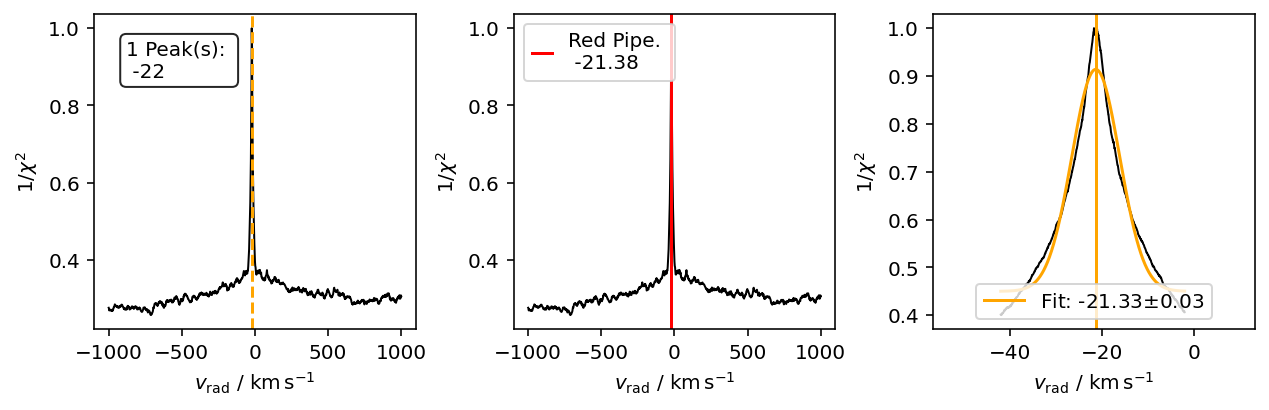

Loop 0 Nr. Wavelength Points: 14302 (95%) 

Star has Teff > 5500 K, nulling CNO

Searching for closest neutral network
Need: 5788 4.44 0.01
Using 3x3x3 model 5750_4.50_0.00 (closest)

Fitting the following labels:
['teff' 'fe_h' 'vmic' 'vsini' 'li_fe' 'c_fe' 'n_fe' 'o_fe' 'na_fe' 'mg_fe'
 'al_fe' 'si_fe' 'k_fe' 'ca_fe' 'sc_fe' 'ti_fe' 'v_fe' 'cr_fe' 'mn_fe'
 'co_fe' 'ni_fe' 'cu_fe' 'zn_fe' 'y_fe' 'zr_fe' 'ba_fe' 'la_fe' 'ce_fe'
 'nd_fe']

Model_labels are the same! Continuing with same model_parameters
Not converged at the end of loop 0. Will start another loop 

Updated logg from 4.44 to 4.44
Mass  1.00 Age  4.21 BC(Ks)  1.47 Lbol  1.00 log(Lbol) -0.00
Teff=5788K, logg=4.44, [Fe/H]=0.01, vmic=0.96km/s, vsini=5.7km/s

 *** STARTING MAJOR LOOP 1 *** 

mass     , 1.00
age      , 4.21
bc_ks    , 1.47

Updated logg from 4.44 to 4.44

Fitting global RV

 Assessing RVs: Red Pipeline = -21.38,  Gaia DR3 = NaN
-22.0 on grid covering -1000.0..(2.0)..1000.0
    [-22.] peaks found by scipy.signal

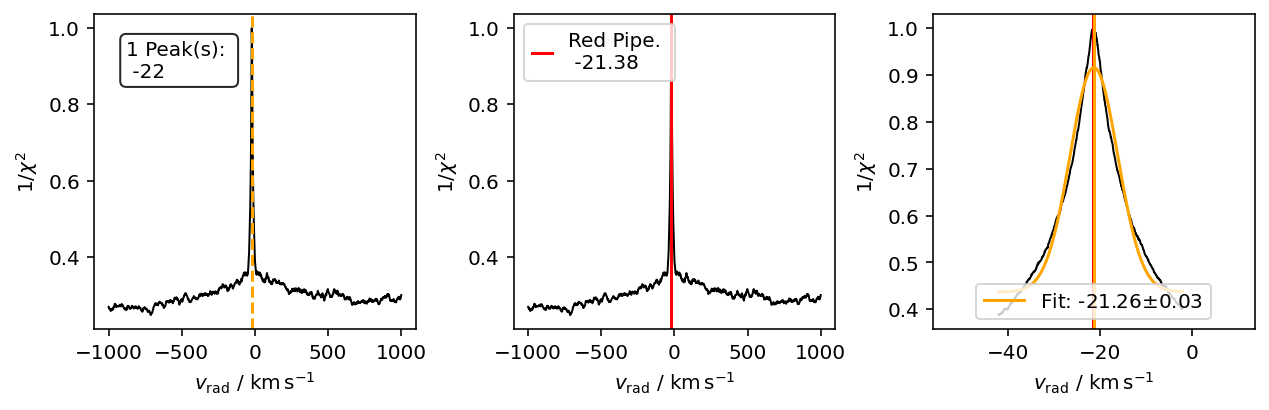

Loop 1 Nr. Wavelength Points: 14300 (95%) 

Star has Teff > 5500 K, nulling CNO

Searching for closest neutral network
Need: 5764 4.43 -0.02
Using 3x3x3 model 5750_4.50_0.00 (closest)

Fitting the following labels:
['teff' 'fe_h' 'vmic' 'vsini' 'li_fe' 'c_fe' 'n_fe' 'o_fe' 'na_fe' 'mg_fe'
 'al_fe' 'si_fe' 'k_fe' 'ca_fe' 'sc_fe' 'ti_fe' 'v_fe' 'cr_fe' 'mn_fe'
 'co_fe' 'ni_fe' 'cu_fe' 'zn_fe' 'y_fe' 'zr_fe' 'ba_fe' 'la_fe' 'ce_fe'
 'nd_fe']

Converged at the end of loop 1. 

Updated logg from 4.43 to 4.43
Mass  0.98 Age  4.96 BC(Ks)  1.48 Lbol  0.99 log(Lbol) -0.01
Teff=5764K, logg=4.43, [Fe/H]=-0.02, vmic=0.95km/s, vsini=5.4km/s


In [48]:
if ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):

    # We loop up to maximum_loops times over the major iteration step
    while (spectrum['opt_loop'] < maximum_loops) & (converged == False):

        if sys.argv[1] == '-f':
            print('\n *** STARTING MAJOR LOOP '+str(spectrum['opt_loop'])+' *** \n')

        if spectrum['opt_loop'] == 0:
            mass, age, bc_ks, lbol, logg = iterate_logg_mass_age_bc_ks_lbol(1000.*spectrum['init_teff'], spectrum['init_logg'], spectrum['init_fe_h'])
        else:
            mass, age, bc_ks, lbol, logg = iterate_logg_mass_age_bc_ks_lbol(1000*model_parameters_opt[model_labels_opt == 'teff'][0], spectrum['init_logg'], model_parameters_opt[model_labels_opt == 'fe_h'][0])

        if sys.argv[1] == '-f':
            print('mass     ,',"{:.2f}".format(mass))
            print('age      ,',"{:.2f}".format(age))
            print('bc_ks    ,',"{:.2f}".format(bc_ks)+'\n')

        if sys.argv[1] == '-f':
            print('Updated logg from '+"{:.2f}".format(spectrum['init_logg'])+' to '+"{:.2f}".format(logg)+'\n')

        spectrum['init_logg'] = logg

        # Major loop 0:
        if spectrum['opt_loop'] == 0:

            # Find best model for given initial Teff/logg/[Fe/H]
            neural_network_model_opt, closest_model, model_name_opt, model_labels_opt = find_best_available_neutral_network_model(
                1000*spectrum['init_teff'],
                spectrum['init_logg'],
                spectrum['init_fe_h']
            )

            # Feed initial values into array
            model_parameters_opt = [spectrum['init_'+label] for label in model_labels_opt]

            # Create model flux for finding best mask for this optimisation loop
            (wave_opt,data_opt,sigma2_opt,model_flux_opt) = match_observation_and_model(model_parameters_opt, model_labels_opt, spectrum, neural_network_model_opt, True, False)
            unmasked_opt = (
                (
                    # Not too large difference between obs and synthesis
                    (~((np.abs(data_opt-model_flux_opt)/np.sqrt(sigma2_opt) > 5) & (np.abs(data_opt-model_flux_opt) > 0.4))) & 
                    # Not in unreliable synthesis region
                    (~np.any(np.array([((wave_opt >= mask_beginning) & (wave_opt <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
                ) |
                # or is in vital line wavelengths (unless they are > 1 away!)
                (
                    (np.abs(data_opt-model_flux_opt) < 1.0) &
                    np.any(np.array([((wave_opt >= line_beginning) & (wave_opt <= line_end)) for (line_beginning, line_end) in zip(vital_lines['line_begin'],vital_lines['line_end'])]),axis=0)
                )
            )

            if sys.argv[1] == '-f':
                print('Initial Nr. Wavelength Points: '+str(len(np.where(unmasked_opt==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked_opt==True)[0])/len(unmasked_opt))))+'%)')
        # For Major loops > 0: We already have a model flux to use for the RV optimisation

        if spectrum['fit_global_rv'] == True:
            if sys.argv[1] == '-f':
                print('Fitting global RV')
            # Optimise RV based on initial or previous RV
            try:
                spectrum['init_vrad'],spectrum['init_e_vrad'] = adjust_rv(spectrum['init_vrad'], wave_opt, data_opt, sigma2_opt, model_flux_opt,small_rv_window = np.max([20.,2*spectrum['init_vsini']]))
            except:
                spectrum['init_vrad'],spectrum['init_e_vrad'] = adjust_rv(spectrum['init_vrad'], wave_opt, data_opt, sigma2_opt, model_flux_opt,small_rv_window = 200.)
        else:
            if sys.argv[1] == '-f':
                print('Keeping global RV fixed at ',spectrum['init_vrad'])

        # Find new mask based on optimised RV
        (wave_opt,data_opt,sigma2_opt,model_flux_opt) = match_observation_and_model(model_parameters_opt, model_labels_opt, spectrum, neural_network_model_opt, True, False)
        unmasked_opt = (
                (
                    # Not too large difference between obs and synthesis
                    (~((np.abs(data_opt-model_flux_opt)/np.sqrt(sigma2_opt) > 5) & (np.abs(data_opt-model_flux_opt) > 0.3))) & 
                    # Not in unreliable synthesis region
                    (~np.any(np.array([((wave_opt >= mask_beginning) & (wave_opt <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
                ) |
                # or is in vital line wavelengths (unless they are > 1 away!)
                (
                    (np.abs(data_opt-model_flux_opt) < 1.0) &
                    np.any(np.array([((wave_opt >= line_beginning) & (wave_opt <= line_end)) for (line_beginning, line_end) in zip(vital_lines['line_begin'],vital_lines['line_end'])]),axis=0)
                )
            )

        if sys.argv[1] == '-f':
            print('Loop '+str(spectrum['opt_loop'])+' Nr. Wavelength Points: '+str(len(np.where(unmasked_opt==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked_opt==True)[0])/len(unmasked_opt))))+'%) \n')

        # Call optimisation routine
        converged, model_flux_opt, model_parameters_opt, model_covariances_opt, neural_network_model_opt, model_name_opt, model_labels_opt, wave_opt, data_opt, sigma2_opt, closest_model = optimise_labels(model_parameters_opt, neural_network_model_opt, model_name_opt, model_labels_opt, wave_opt, data_opt, sigma2_opt, unmasked_opt, spectrum['opt_loop'])

        if (converged != True) & (spectrum['opt_loop'] < maximum_loops - 1):
            if sys.argv[1] == '-f':
                print('Not converged at the end of loop '+str(spectrum['opt_loop'])+'. Will start another loop \n')
        elif (converged == True):
            print('Converged at the end of loop '+str(spectrum['opt_loop'])+'. \n')
        else:
            print('Not converged at the end of final loop '+str(spectrum['opt_loop'])+'! \n')
            success = False

        mass, age, bc_ks, lbol, logg = iterate_logg_mass_age_bc_ks_lbol(1000*model_parameters_opt[model_labels_opt == 'teff'][0], spectrum['init_logg'], model_parameters_opt[model_labels_opt == 'fe_h'][0])
        if sys.argv[1] == '-f':
            print('Updated logg from '+"{:.2f}".format(spectrum['init_logg'])+' to '+"{:.2f}".format(logg))
        spectrum['init_logg'] = logg

        print('Mass ',"{:.2f}".format(mass),'Age ',"{:.2f}".format(age),'BC(Ks) ',"{:.2f}".format(bc_ks),'Lbol ',"{:.2f}".format(lbol),'log(Lbol)',"{:.2f}".format(np.log10(lbol)))

        print(
            'Teff='+str(int(1000*model_parameters_opt[model_labels_opt == 'teff'][0]))+'K, '+ \
            'logg='+str(np.round(spectrum['init_logg'],decimals=2))+', '+ \
            '[Fe/H]='+str(np.round(model_parameters_opt[model_labels_opt == 'fe_h'][0],decimals=2))+', '+ \
            'vmic='+str(np.round(model_parameters_opt[model_labels_opt == 'vmic'][0],decimals=2))+'km/s, '+ \
            'vsini='+str(np.round(model_parameters_opt[model_labels_opt == 'vsini'][0],decimals=1))+'km/s'
        )

        spectrum['opt_loop'] += 1
else:
    success = False

# The end: plot full spectrum

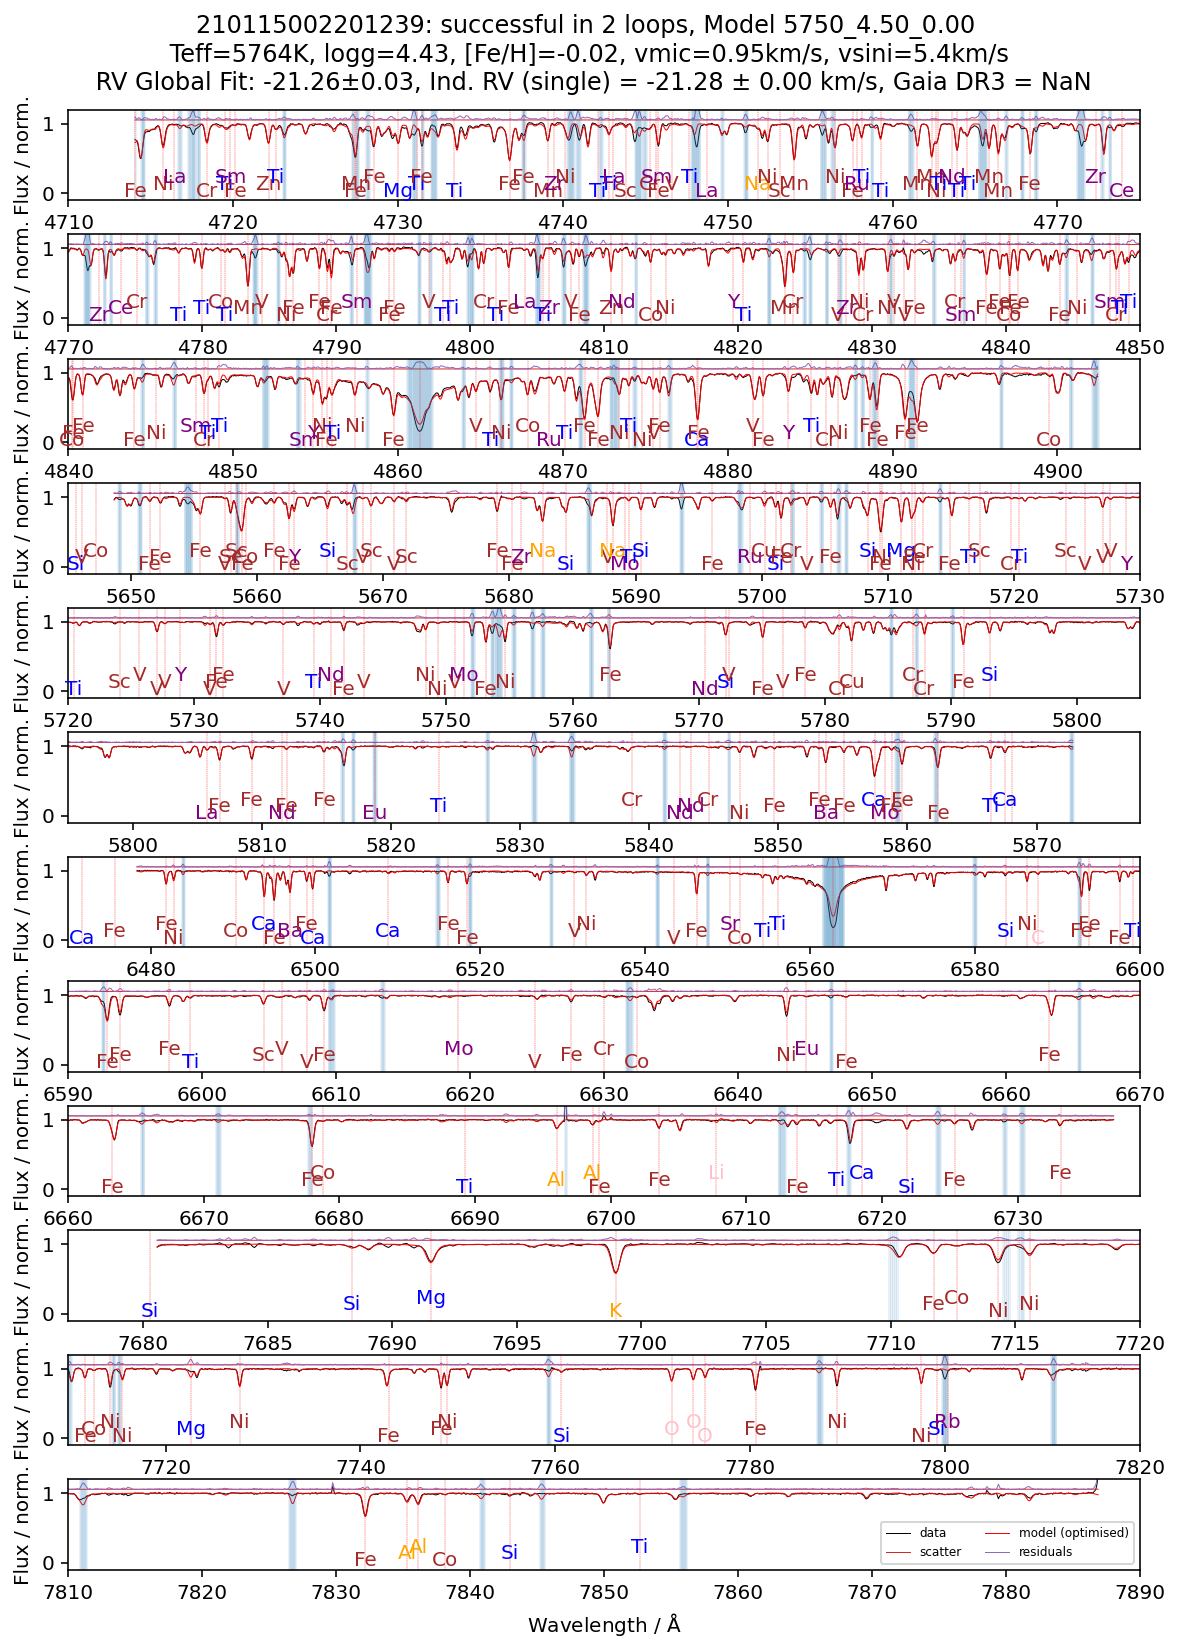

In [49]:
if ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):

    if success:
        info_line_1 = str(spectrum['sobject_id'])+': successful in '+str(spectrum['opt_loop'])+' loops, Model '+model_name_opt
    else:
        info_line_1 = str(spectrum['sobject_id'])+': not successful, Model '+model_name_opt

    if (spectrum['flag_sp'] & flag_sp_closest_3x3x3_model_not_available) > 0:
        if (spectrum['flag_sp'] & flag_sp_closest_extra6_model_not_available) > 0:
            info_line_1 = info_line_1+' (extrapol. 27+7)'
        else:
            info_line_1 = info_line_1+' (extrapol. 27)'
    elif (spectrum['flag_sp'] & flag_sp_closest_extra6_model_not_available) > 0:
        info_line_1 = info_line_1+' (extrapol. 7)'


    if success:
        info_line_2 = 'Teff='+str(int(1000*model_parameters_opt[model_labels_opt == 'teff'][0]))+'K, '+ \
            'logg='+str(np.round(spectrum['init_logg'],decimals=2))+', '+ \
            '[Fe/H]='+str(np.round(model_parameters_opt[model_labels_opt == 'fe_h'][0],decimals=2))+', '+ \
            'vmic='+str(np.round(model_parameters_opt[model_labels_opt == 'vmic'][0],decimals=2))+'km/s, '+ \
            'vsini='+str(np.round(model_parameters_opt[model_labels_opt == 'vsini'][0],decimals=1))+'km/s'
    else:
        info_line_2 = 'Teff='+str(int(1000*spectrum['init_teff']))+'K, '+ \
            'logg='+str(np.round(spectrum['init_logg'],decimals=2))+', '+ \
            '[Fe/H]='+str(np.round(spectrum['init_fe_h'],decimals=2))+', '+ \
            'vmic='+str(np.round(spectrum['init_vmic'],decimals=2))+'km/s, '+ \
            'vsini='+str(np.round(spectrum['init_vsini'],decimals=1))+'km/s'

    if spectrum['fit_global_rv'] == True:
        info_line_3 = 'RV Global Fit: '+str(np.round(spectrum['init_vrad'],decimals=2))+'±'+str(np.round(spectrum['init_e_vrad'],decimals=2))
    else:
        info_line_3 = 'RV Global Fix'

    info_line_3 = info_line_3+', Ind. RV (single) = '+"{:.2f}".format(rv_mean)+r' ± '+"{:.2f}".format(rv_sigma)+' km/s'

    info_line_3 = info_line_3+', Gaia DR3 = '
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        info_line_3 = info_line_3+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])+', '
    else:
        info_line_3 = info_line_3+'NaN'

    fig = plot_spectrum(
        wave_opt,
        [
            data_opt,
            model_flux_opt
        ],
        np.sqrt(sigma2_opt),
        ~unmasked_opt,
        info_line_1,
        info_line_2,
        info_line_3
    )

    file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
    Path(file_directory).mkdir(parents=True, exist_ok=True)

    fig.savefig(file_directory+str(spectrum['sobject_id'])+'_plxcom_fit_comparison.pdf',overwrite=True,bbox_inches='tight')

    # show plot if working interactively
    if sys.argv[1] == '-f':
        plt.show()
    plt.close()

# Save Results

In [50]:
if ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):
    # Save spectrum
    save_spectrum = Table()
    save_spectrum['wave'] = wave_opt
    save_spectrum['sob'] = data_opt
    save_spectrum['uob'] = np.sqrt(sigma2_opt)
    save_spectrum['smod'] = model_flux_opt
    save_spectrum['mob'] = unmasked_opt

    file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
    Path(file_directory).mkdir(parents=True, exist_ok=True)

    save_spectrum.write(file_directory+str(spectrum['sobject_id'])+'_plxcom_fit_spectrum.fits',overwrite=True)

In [51]:
if ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):
    # Save covariances
    np.savez(
        file_directory+str(spectrum['sobject_id'])+'_plxcom_fit_covariances.npz',
        model_labels = model_labels_opt,
        model_name = model_name_opt,
        model_parameters = model_parameters_opt,
        model_covariances = model_covariances_opt,
    )

In [52]:
np.savetxt(file_directory+str(spectrum['sobject_id'])+'_plxcom_sobject_ids.txt',spectrum['sobject_ids'],fmt='%s')

# Setup our output data

In [53]:
output = Table()
file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

col = Table.Column(
    name='sobject_id',
    data = [spectrum['sobject_id']],
    description='GALAH unique identifier; spectrum stacked via tmass_id',
    unit='')
output.add_column(col)
col = Table.Column(
    name='tmass_id',
    data = [spectrum['tmass_id']],
    description='2MASS ID (same for stacked spectra)',
    unit='')
output.add_column(col)
col = Table.Column(
    name='fit_global_rv',
    data = [spectrum['fit_global_rv']],
    description='Global RV fixed or fitted',
    unit='')
output.add_column(col)

for label in ['gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [np.int64(spectrum[label])],
        description=description[label],
        unit=units[label])
    output.add_column(col)

col = Table.Column(
    name='flag_sp_fit',
    data = [np.int32(spectrum['flag_sp'])],
    description=description['flag_sp'],
    unit='')
output.add_column(col)

if spectrum['fit_global_rv']:
    rv_value = np.float32(spectrum['init_vrad'])
    if 'init_e_vrad' in spectrum.keys():
        e_rv_value = np.float32(spectrum['init_e_vrad'])
    else:
        e_rv_value = np.float32(np.nan)
else:
    rv_value = rv_mean
    e_rv_value = rv_sigma

col = Table.Column(
    name='rv_gauss',
    data = [rv_value],
    description=description['rv_gauss'],
    unit=units['rv_gauss'])
output.add_column(col)
col = Table.Column(
    name='e_rv_gauss',
    data = [e_rv_value],
    description='Fitting uncertainty for '+description['rv_gauss'],
    unit=units['rv_gauss'])
output.add_column(col)

if ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):
    diagonal_covariance_entries_sqrt = np.sqrt(np.diag(model_covariances_opt))

# These are the labels that our interpolation routine was trained on
model_interpolation_labels = np.array(['teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'])

# flag_x_fe_values:
flag_x_fe_value_no_detection = 1
flag_x_fe_value_not_measured = 2
flag_x_fe_value_no_success = 4

if not ((len(spectrum['available_ccds']) > 0) & np.isfinite(extra_info['r_med'])):
    spectrum['init_logg'] = np.nan
    model_labels_opt = []
    mass = np.nan
    age = np.nan
    bc_ks = np.nan
    lbol = np.nan
    model_name_opt = 'teff_logg_fe_h'
    closest_model = 'teff_logg_fe_h'

# Let's loop through all the parameters that are part of the spectrum_interpolation routine
for label in model_interpolation_labels:
        
    # For each of the labels, we start with an unflagged value of 0
    flag_x_fe = 0

    if label == 'logg':
        col = Table.Column(
            name=label,
            data = [spectrum['init_logg']],
            description=description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(np.NaN)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='flag_'+label,
            data = [np.int32(flag_x_fe)],
            description='Quality flag for '+description[label],
            unit='')
        output.add_column(col)    

    # We know that some labels do not influence the spectrum shape at all
    elif label not in model_labels_opt:

        # If that is the case, we do not measure them, and raise the flag_x_fe
        flag_x_fe += flag_x_fe_value_not_measured

        # To have the same output format, fill the needed columns with NaN / flag_x_fe
        col = Table.Column(
            name=label,
            data = [np.float32(np.NaN)],
            description=description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(np.NaN)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='flag_'+label,
            data = [np.int32(flag_x_fe)],
            description='Quality flag for '+description[label],
            unit='')
        output.add_column(col)

    # Let's check out the labels that have been fitted
    else:
        label_index = np.where(label == model_labels_opt)[0][0]

        label_value = model_parameters_opt[label_index]
        if label == 'teff':
            label_value *= 1000

        col = Table.Column(
            name=label,
            data = [np.float32(label_value)],
            description=description[label],
            unit=units[label])
        output.add_column(col)

        label_value = diagonal_covariance_entries_sqrt[label_index]
        if label == 'teff':
            label_value *= 1000

        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(label_value)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)

        # For [Fe/H] and [X/Fe], we do an additional test, if the lines are actually sufficiently detected
        if ((label == 'fe_h') | (label[-3:] == '_fe')):

            # Replace the particular value for [X/Fe] or [Fe/H] with the lowest value of the training routine
            model_parameters_low_xfe = np.array(model_parameters_opt)
            
            if label == 'fe_h':
                model_parameters_low_xfe[label_index] -= 0.25
            else:
                model_parameters_low_xfe[label_index] = (neural_network_model_opt[-2])[(label == model_interpolation_labels)][0]

            # Create the spectrum with lowest [X/Fe] or [Fe/H]
            (wave_low_xfe,data_low_xfe,data_sigma2_low_xfe,model_low_xfe) = match_observation_and_model(
                model_parameters_low_xfe, 
                model_labels_opt, 
                spectrum,
                neural_network_model_opt,
                True, 
                False
            )

            # Let's calculate the absolute difference between the spectra
            absolute_difference = np.abs(model_flux_opt[unmasked_opt].clip(min=0.0,max=1.0)-model_low_xfe[unmasked_opt].clip(min=0.0,max=1.0))

            # Let's compare the absolute difference to the measurement noise
            difference_with_respect_to_noise = absolute_difference / np.sqrt(sigma2_opt[unmasked_opt])

            # If the difference is not larger than 3xnoise, we raise a flag that we do not have a detection
            if not np.max(difference_with_respect_to_noise) > 3:
                flag_x_fe += flag_x_fe_value_no_detection

            if not success:
                flag_x_fe += flag_x_fe_value_no_success

            col = Table.Column(
                name='flag_'+label,
                data = [np.int32(flag_x_fe)],
                description='Quality flag for '+description[label],
                unit='')
            output.add_column(col)

for data, label in zip([mass,age,bc_ks,extra_info['a_ks'],lbol,extra_info['r_med'],extra_info['r_lo'],extra_info['r_hi']],['mass','age','bc_ks','a_ks','lbol','r_med','r_lo','r_hi']):
    col = Table.Column(
        name=label,
        data = np.float32(data),
        description=label,
        unit='')
    output.add_column(col)

# Let's safe the default model that we use to allow to reproduce the spectra
col = Table.Column(
    name='model_name',
    data = [model_name_opt],
    description=description['model_name'],
    unit=units['model_name'])
output.add_column(col)

col = Table.Column(
    name='closest_model',
    data = [closest_model],
    description=description['closest_model'],
    unit=units['closest_model'])
output.add_column(col)

end_time = time.time() - start_time

col = Table.Column(
    name='comp_time',
    data = [float(end_time)],
    description='Computational time used on this sobject_id',
    unit='s')
output.add_column(col)

col = Table.Column(
    name='opt_loop',
    data = [spectrum['opt_loop']],
    description='Nr of optimisation loops',
    unit='')
output.add_column(col)

# And save!
output.write(file_directory+str(spectrum['sobject_id'])+'_plxcom_fit_results.fits',overwrite=True)

print('Duration: '+str(np.round(end_time,decimals=1))+' for sobject_id '+str(spectrum['sobject_id']))

Duration: 104.3 for sobject_id 210115002201239


In [54]:
output

sobject_id,tmass_id,fit_global_rv,gaia_edr3_source_id,flag_sp_fit,rv_gauss,e_rv_gauss,teff,cov_e_teff,logg,cov_e_logg,flag_logg,fe_h,cov_e_fe_h,flag_fe_h,vmic,cov_e_vmic,vsini,cov_e_vsini,li_fe,cov_e_li_fe,flag_li_fe,c_fe,cov_e_c_fe,flag_c_fe,n_fe,cov_e_n_fe,flag_n_fe,o_fe,cov_e_o_fe,flag_o_fe,na_fe,cov_e_na_fe,flag_na_fe,mg_fe,cov_e_mg_fe,flag_mg_fe,al_fe,cov_e_al_fe,flag_al_fe,si_fe,cov_e_si_fe,flag_si_fe,k_fe,cov_e_k_fe,flag_k_fe,ca_fe,cov_e_ca_fe,flag_ca_fe,sc_fe,cov_e_sc_fe,flag_sc_fe,ti_fe,cov_e_ti_fe,flag_ti_fe,v_fe,cov_e_v_fe,flag_v_fe,cr_fe,cov_e_cr_fe,flag_cr_fe,mn_fe,cov_e_mn_fe,flag_mn_fe,co_fe,cov_e_co_fe,flag_co_fe,ni_fe,cov_e_ni_fe,flag_ni_fe,cu_fe,cov_e_cu_fe,flag_cu_fe,zn_fe,cov_e_zn_fe,flag_zn_fe,rb_fe,cov_e_rb_fe,flag_rb_fe,sr_fe,cov_e_sr_fe,flag_sr_fe,y_fe,cov_e_y_fe,flag_y_fe,zr_fe,cov_e_zr_fe,flag_zr_fe,mo_fe,cov_e_mo_fe,flag_mo_fe,ru_fe,cov_e_ru_fe,flag_ru_fe,ba_fe,cov_e_ba_fe,flag_ba_fe,la_fe,cov_e_la_fe,flag_la_fe,ce_fe,cov_e_ce_fe,flag_ce_fe,nd_fe,cov_e_nd_fe,flag_nd_fe,sm_fe,cov_e_sm_fe,flag_sm_fe,eu_fe,cov_e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,model_name,closest_model,comp_time,opt_loop
,,,,,km / s,km / s,K,K,log(cm.s**-2),log(cm.s**-2),,dex,dex,,km / s,km / s,km / s,km / s,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,dex,dex,,,,,,,,,,,,s,
int64,str5,bool,int64,int32,float32,float32,float32,float32,float64,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,str14,str14,float64,int64
210115002201239,VESTA,True,0,0,-21.255915,0.030143479,5764.1772,0.7045196,4.433135104564495,nan,0,-0.016221732,0.0005096726,0,0.94891864,0.0019067302,5.436708,0.0049550436,0.1394781,0.005380007,0,-0.0029619301,0.0011511415,0,0.662719,0.0023725405,0,0.08110585,0.007139543,0,0.17670639,0.001281503,0,0.20465375,0.0011934958,0,0.27357903,0.0046519022,0,0.031473443,0.000816578,0,0.1397641,0.00734469,0,0.047661398,0.0017385334,0,0.0038408951,0.0015722923,0,0.024086814,0.00081426906,0,-0.13709779,0.0012653717,0,-0.0033580502,0.0006968713,0,0.12769161,0.0009282953,0,-0.10862087,0.0014622203,0,0.030380914,0.0006017413,0,-0.18781443,0.0022151088,0,-0.013137794,0.002451464,0,nan,nan,2,nan,nan,2,0.009821477,0.002117007,0,-0.40298668,0.0066090403,0,nan,nan,2,nan,nan,2,0.036620237,0.0031442104,0,-0.03299176,0.0054708263,0,-0.2583093,0.008054473,0,-0.08048562,0.0045004473,0,nan,nan,2,nan,nan,2,0.982594,4.9558516,1.4827926,0.0,0.98828673,10.0,9.99001,10.01001,5750_4.50_0.00,5750_4.50_0.00,104.2766854763031,2


In [55]:
# if spectrum['sobject_id'] in [210115002201239,140314005201392]:

#     for label in ['li_fe','c_fe','n_fe','o_fe','na_fe','ba_fe']:
                
#         changes = [-1.00,0.50,0.00,0.50,1.00,1.50,2.00]
#         if label == 'li_fe':
#             changes = [0.00,1.05,2.75,3.26,4.00]

#         for change in changes:
#             label_index = np.where(label == model_labels_opt)[0][0]

#             model_parameters_low_xfe = np.array(model_parameters_opt)
#             model_parameters_low_xfe[label_index] = change

#             # Create the spectrum with lowest [X/Fe] or [Fe/H]
#             (wave_low_xfe,data_low_xfe,data_sigma2_low_xfe,model_low_xfe) = match_observation_and_model(
#                 model_parameters_low_xfe, 
#                 model_labels_opt, 
#                 spectrum,
#                 neural_network_model_opt,
#                 True, 
#                 False
#             )

#             example = Table()
#             example['wave'] = wave_low_xfe
#             example['smod'] = model_low_xfe
#             example.write('../validation/example_gradients/'+str(spectrum['sobject_id'])+'_grad_'+label+'_'+"{:.2f}".format(change)+'.fits',overwrite=True)